In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

In [3]:
# 뉴스 데이터만 불러옴
import os
news2020 =  pd.read_csv("data/2020.01.01_2020.12.31_1.csv")
news2021 =  pd.read_csv("data/2021.01.01_2021.12.31_1.csv")
news2022 = pd.read_csv("data/2022.01.01_2022.12.25_1.csv")


In [4]:
# 정규 표현식으로 전처리
import re

def preprocessing(text):
    text = re.sub(r"[^가-힣0-9\s]", " ", text) #한글이랑 숫자, 공백만 남기기
    text = re.sub(r"\s+", " ", text) #중복 공백 없애기
    text = text.strip() #앞뒤 공백 없애기
    return text

In [5]:
# 날짜 파생변수 생성
news2020["날짜"] = 2020
news2021["날짜"] = 2021
news2022["날짜"] = 2022

In [6]:
# 일단 다 합쳤어요 (예전 전처리 때문에 있는 과정ㅠㅠ)
news = pd.concat([news2020, news2021, news2022])

In [7]:
news.rename(columns = {'0' : '제목'}, inplace = True)

In [8]:
from tqdm import tqdm
tqdm.pandas()

news["제목"] = news["제목"].progress_map(preprocessing)

100%|██████████| 12000/12000 [00:00<00:00, 273997.23it/s]


In [9]:
news.duplicated(subset=["제목"]).sum()

3681

In [10]:
news = news.drop_duplicates(['제목'])

In [11]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      8319 non-null   object
 1   날짜      8319 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 195.0+ KB


In [12]:
news = news.reset_index(drop=True, inplace=False)

In [13]:
from konlpy.tag import Mecab

In [14]:
mecab = Mecab()

In [15]:
# 명사만 남게 전처리
news["명사"] = news["제목"].map(mecab.nouns).astype(str).progress_map(preprocessing)

100%|██████████| 8319/8319 [00:00<00:00, 185113.51it/s]


In [16]:
news

,제목,날짜,명사
0,은평구 반려동물 문화교실 댕댕이 스쿨 운영,2020,은평구 반려 동물 문화 교실 댕댕이 스쿨 운영
1,새해부터 반려동물 미용사 나무의사도 신중년 고용장려금 받는다,2020,새해 반려 동물 미용사 나무 의사 중년 고용 장려금
2,반려식물로 코로나 우울 해소,2020,반려 식물 코로나 우울 해소
3,우리 아이와 반려동물 함께 생활해도 괜찮을까,2020,우리 아이 반려 동물 생활
4,영상 반려동물 식품의 세계화 정부지원 받아 글로벌기업으로 우뚝,2020,영상 반려 동물 식품 세계 정부 지원 글로벌 기업
...,...,...,...
8314,펫푸드협회 반려동물 장수 위한 펫푸드 팁 소개,2022,펫 푸드 협회 반려 동물 장수 펫 푸드 팁 소개
8315,수원시 반려동물 문화교실 참여자 선착순 모집,2022,수원시 반려 동물 문화 교실 참여 선착순 모집
8316,정황근 장관 반려동물산업 스마트팜 등 규제 대못 뽑겠다,2022,정황근 장관 반려 동물 산업 스마트 팜 등 규제 대못
8317,반려동물 사고 예방 펫티켓 운동 확산돼야,2022,반려 동물 사고 예방 펫 티켓 운동 확산


In [17]:
from math import log

In [18]:
docs2020 = news.loc[news["날짜"]==2020, "명사"].values.tolist()
docs2021 = news.loc[news["날짜"]==2021, "명사"].values.tolist()
docs2022 = news.loc[news["날짜"]==2022, "명사"].values.tolist()

In [19]:
# tf-idf 구하기위한 라이브러리
from sklearn.feature_extraction.text import TfidfVectorizer
import codecs

In [20]:
def tfidf(docs):
    cv = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)

    tfidf = cv.fit_transform(docs)

    word_count = pd.DataFrame({
        '단어': cv.get_feature_names(),
        'tf-idf': tfidf.sum(axis=0).flat
    })

    return word_count.sort_values('tf-idf', ascending=False)

In [21]:
tfidf2020 = tfidf(docs2020)
tfidf2020

/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,단어,tf-idf
23,동물,667.450154
30,반려,657.321748
7,건강,91.094996
29,문화,79.993412
85,출시,74.600880
...,...,...
35,복귀,16.534684
66,이혼,16.378994
74,정책,16.148053
5,강좌,13.897884


In [22]:
tfidf2021 = tfidf(docs2021)
tfidf2021

/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,단어,tf-idf
28,동물,636.935103
35,반려,625.483922
33,문화,76.252163
7,건강,76.246295
53,센터,64.615689
...,...,...
99,확대,18.505395
87,코리아,18.480611
54,수상,17.729801
80,집중,17.724148


In [23]:
tfidf2022 = tfidf(docs2022)
tfidf2022

/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,단어,tf-idf
22,동물,670.849242
29,반려,658.989386
27,문화,106.461410
5,개최,85.443613
82,출시,76.360162
...,...,...
58,업무,18.744630
25,디자인,18.410478
65,의약품,18.032799
95,해변,17.945835


In [24]:
# 3개년도의 tf-idf를 다 확인해보고 전처리
df = pd.merge(left = tfidf2020 , right = pd.merge(left = tfidf2021 , right = tfidf2022, how = "outer", on = "단어"), how = "outer", on = "단어")
df.columns = ['단어','2020','2021','2022']
df = df.dropna()
df

,단어,2020,2021,2022
0,동물,667.450154,636.935103,670.849242
1,반려,657.321748,625.483922,658.989386
2,건강,91.094996,76.246295,71.422306
3,문화,79.993412,76.252163,106.461410
4,출시,74.600880,49.583128,76.360162
5,센터,70.488414,64.615689,71.356745
7,강아지,58.271610,21.877836,30.291885
8,서비스,57.147694,27.724989,43.752185
9,유기,54.957537,36.146217,52.232558
10,산업,53.230467,50.958437,55.008418


In [25]:
df["총합"] = df.sum(axis=1)
df = df.sort_values('총합', ascending=False)

pd.set_option('display.max_columns', None)

# 앞에 두개는 반려, 동물이라서 뺐습니다
df = df[2:].drop(columns="총합")
df.set_index(keys=["단어"], inplace=True, drop=True)
df = df.T.reset_index()
df

/var/folders/k5/knpgq_1j4xg_p46vnk55j0gm0000gn/T/ipykernel_46087/2617503508.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df["총합"] = df.sum(axis=1)


단어,index,문화,건강,센터,출시,개최,시장,지원,산업,유기,복지,케어,이야기,병원,서비스,용품,사료,대상,입양,고양이,강아지,진행,보험,사업,브랜드,기업,사랑,시대,교육,보호,한국,운영,보건,페어,가족,관리,서울,가구,수상,도시,행복,부산,교실
0,2020,79.993412,91.094996,70.488414,74.600880,50.381501,48.297371,47.306074,53.230467,54.957537,31.659549,42.426555,44.801974,42.638658,57.147694,47.258292,45.812138,36.202044,45.276017,47.189464,58.271610,38.112270,45.005673,31.572165,36.687933,35.790649,27.500267,40.891024,28.668318,26.539728,31.962017,28.141121,19.916469,24.673535,25.885878,24.375432,24.948847,25.410667,18.484892,21.337315,25.469286,26.999430,27.008178
1,2021,76.252163,76.246295,64.615689,49.583128,41.745014,64.597295,44.161491,50.958437,36.146217,33.173432,40.933878,55.014338,49.864334,27.724989,27.647257,39.385522,31.399036,28.688288,38.019847,21.877836,26.256170,26.842248,34.171631,37.907534,39.889304,31.046949,29.168751,27.253350,24.371307,20.845405,28.442813,31.902312,23.258293,22.108271,21.689419,27.965151,21.114683,17.729801,25.093934,23.018542,23.848734,22.421406
2,2022,106.461410,71.422306,71.356745,76.360162,85.443613,56.822758,69.333343,55.008418,52.232558,76.350830,57.380119,38.040136,43.932270,43.752185,48.665815,36.174033,53.071322,45.589542,26.543052,30.291885,45.978425,37.394912,43.191522,27.425101,26.126052,39.670785,27.157689,37.723590,39.214963,31.531801,22.893490,26.912422,30.416020,30.312451,29.946097,22.932693,29.140426,39.198665,28.368380,26.229503,23.591778,23.191773


In [26]:
cols = df.columns
cols

Index(['index', '문화', '건강', '센터', '출시', '개최', '시장', '지원', '산업', '유기', '복지',
       '케어', '이야기', '병원', '서비스', '용품', '사료', '대상', '입양', '고양이', '강아지', '진행',
       '보험', '사업', '브랜드', '기업', '사랑', '시대', '교육', '보호', '한국', '운영', '보건', '페어',
       '가족', '관리', '서울', '가구', '수상', '도시', '행복', '부산', '교실'],
      dtype='object', name='단어')

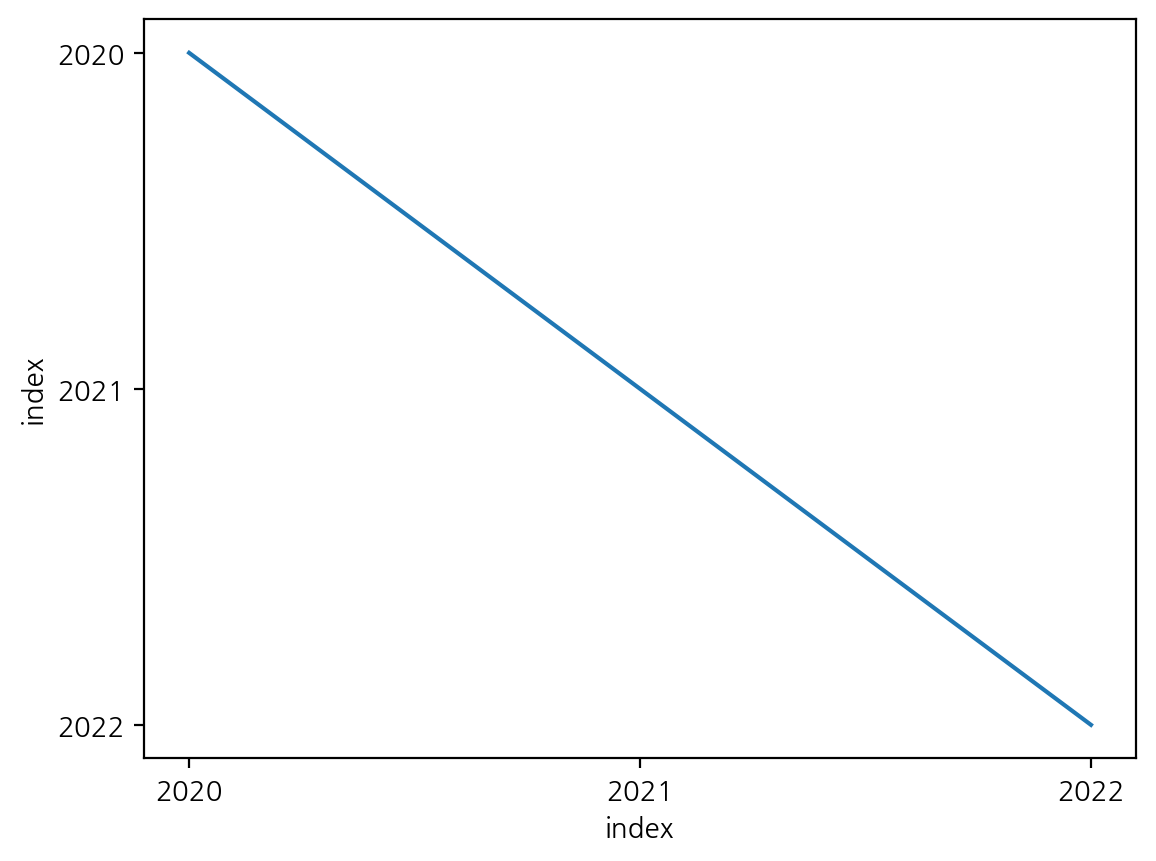

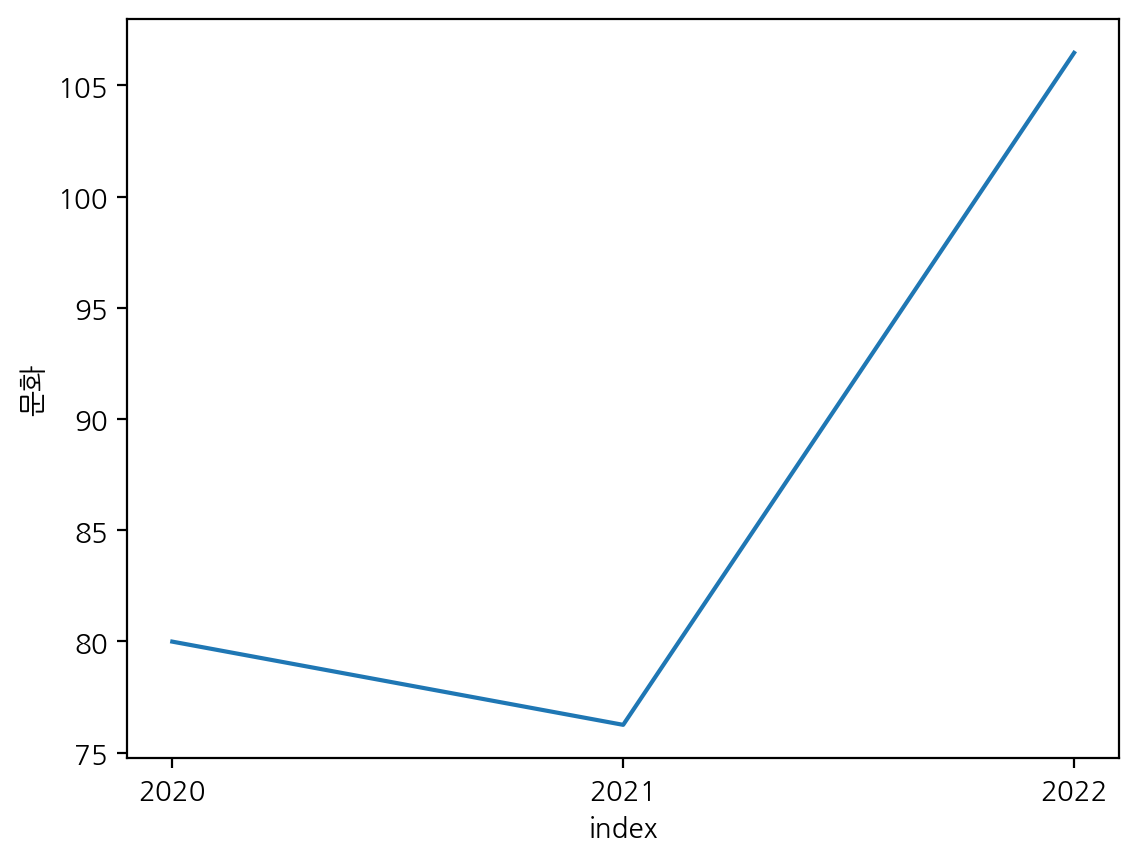

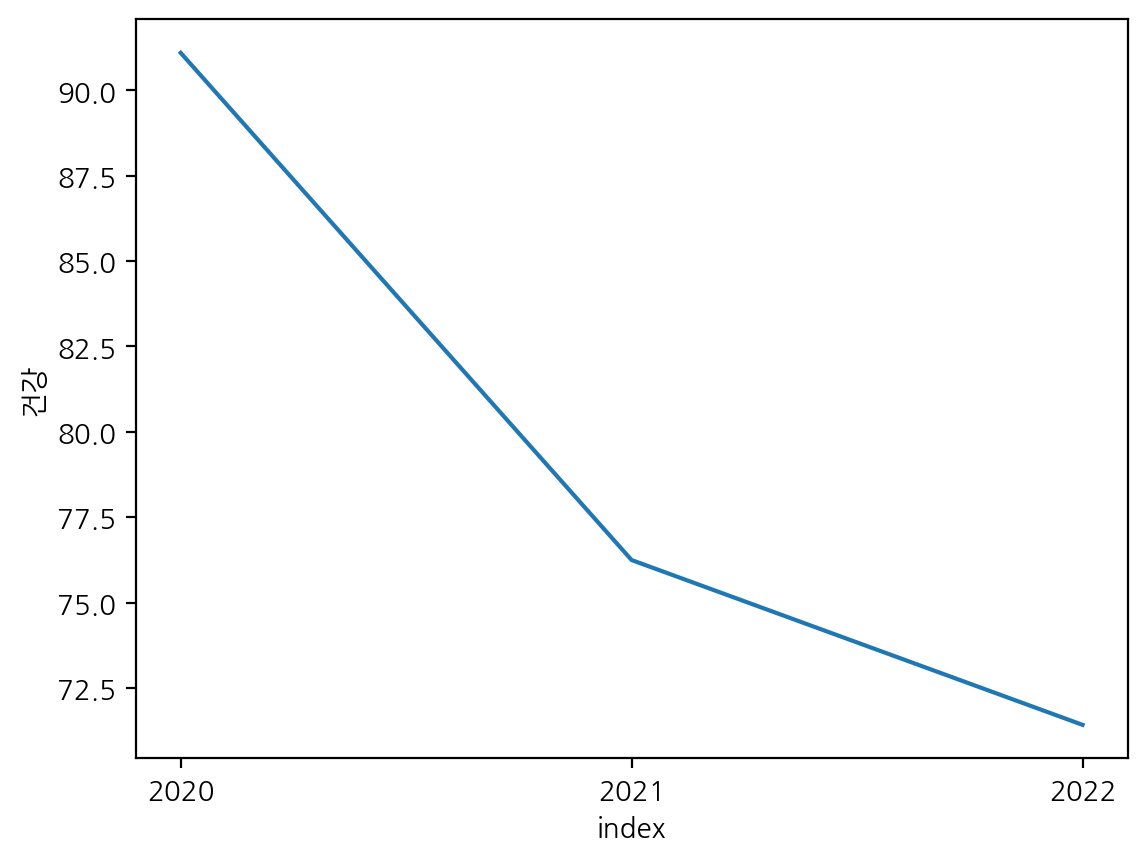

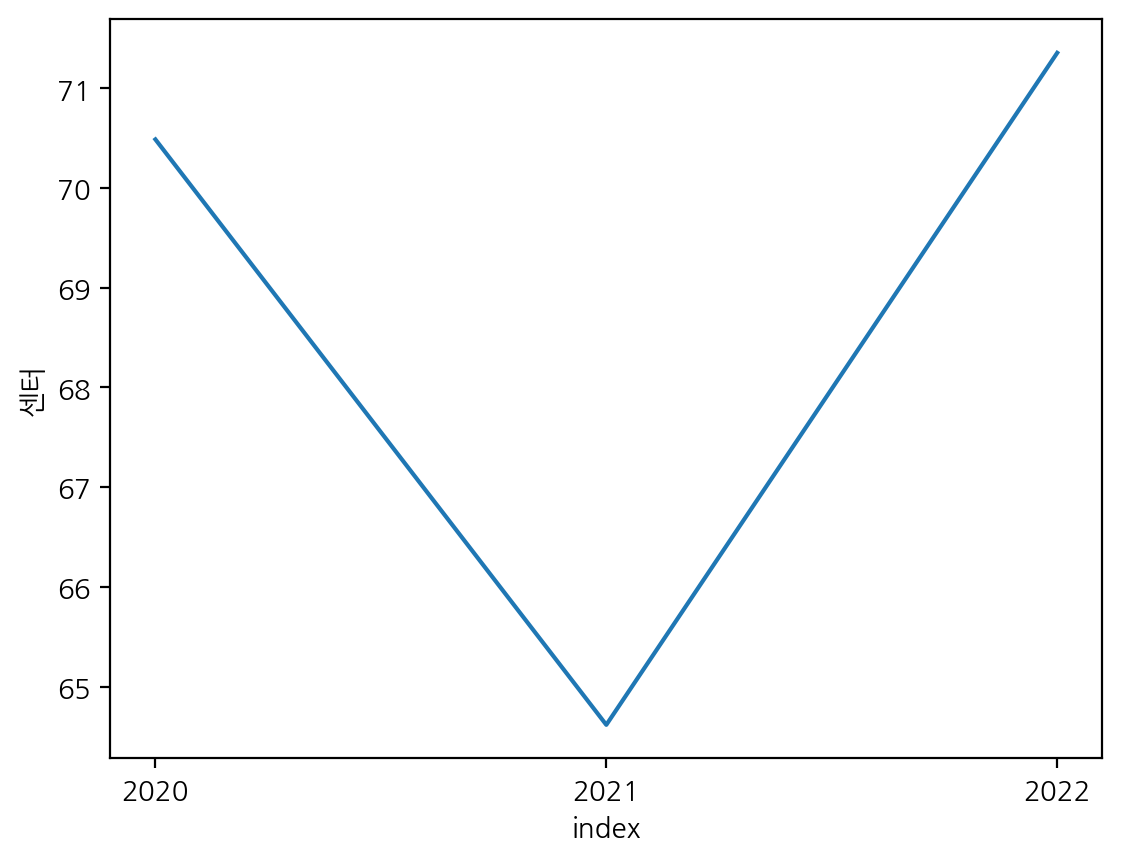

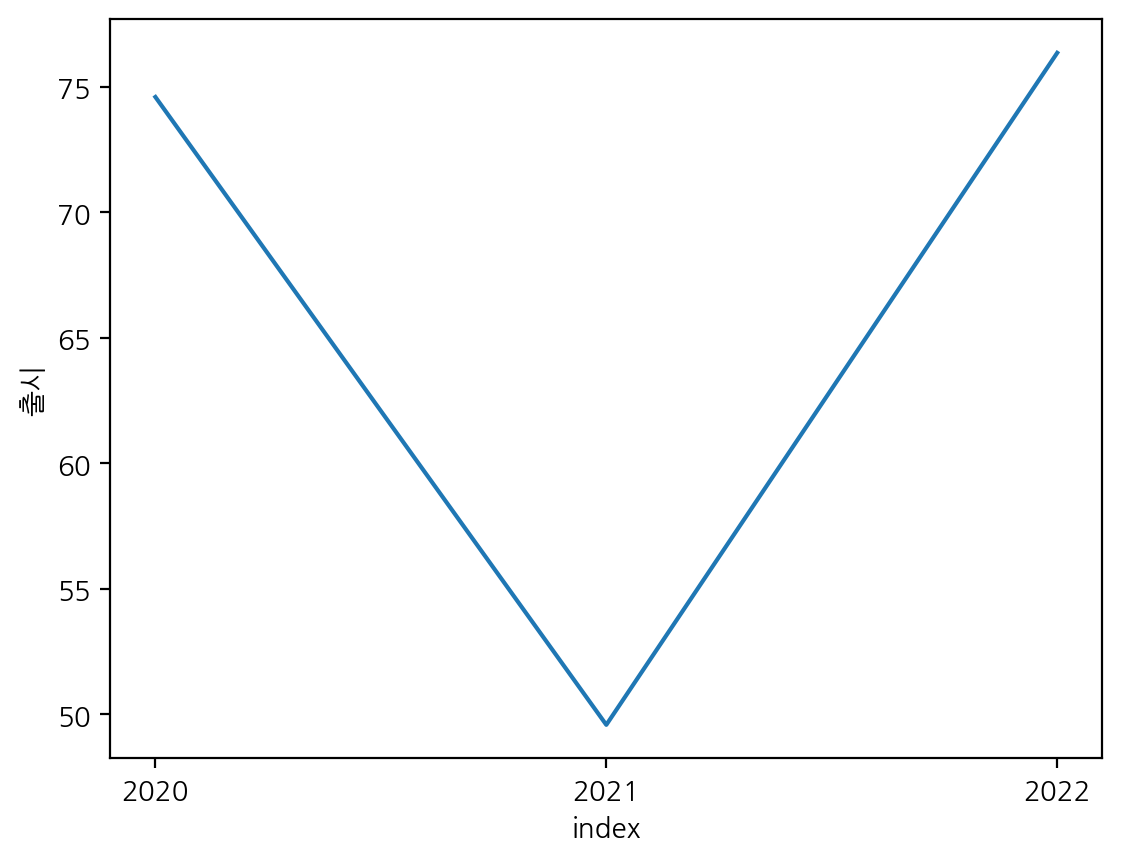

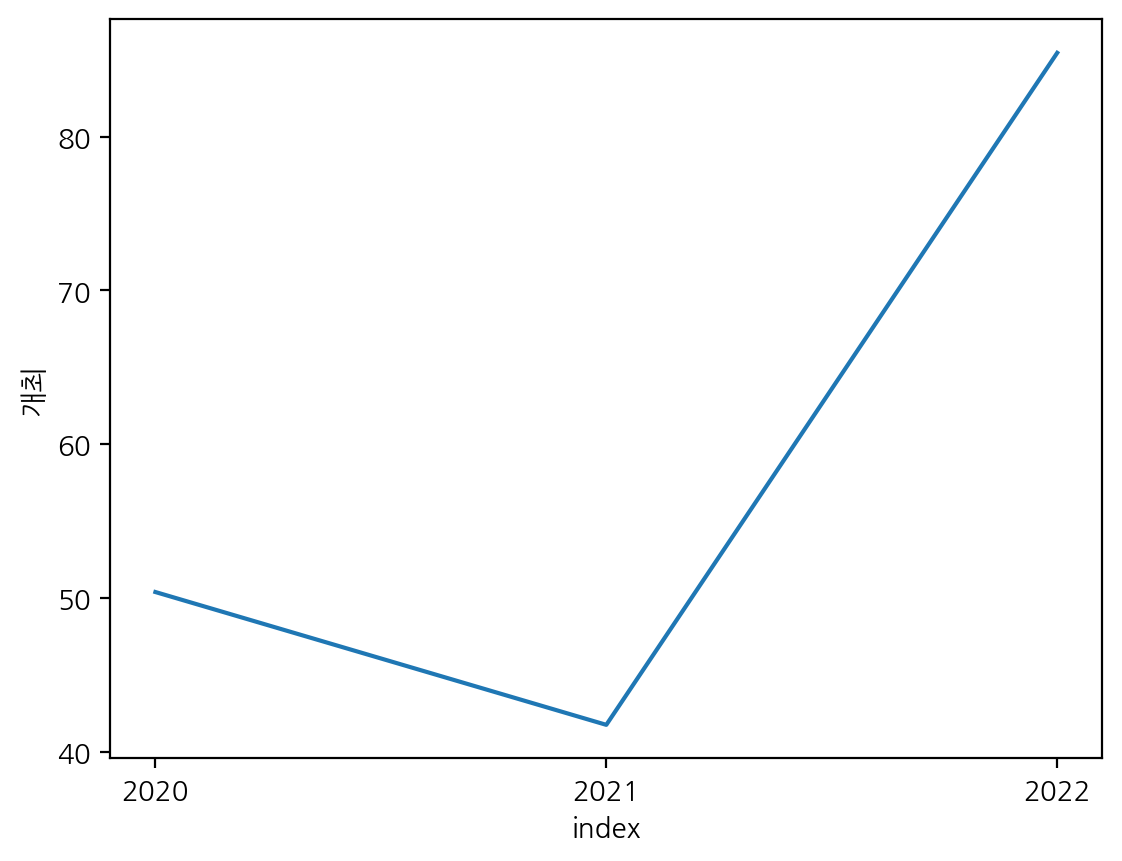

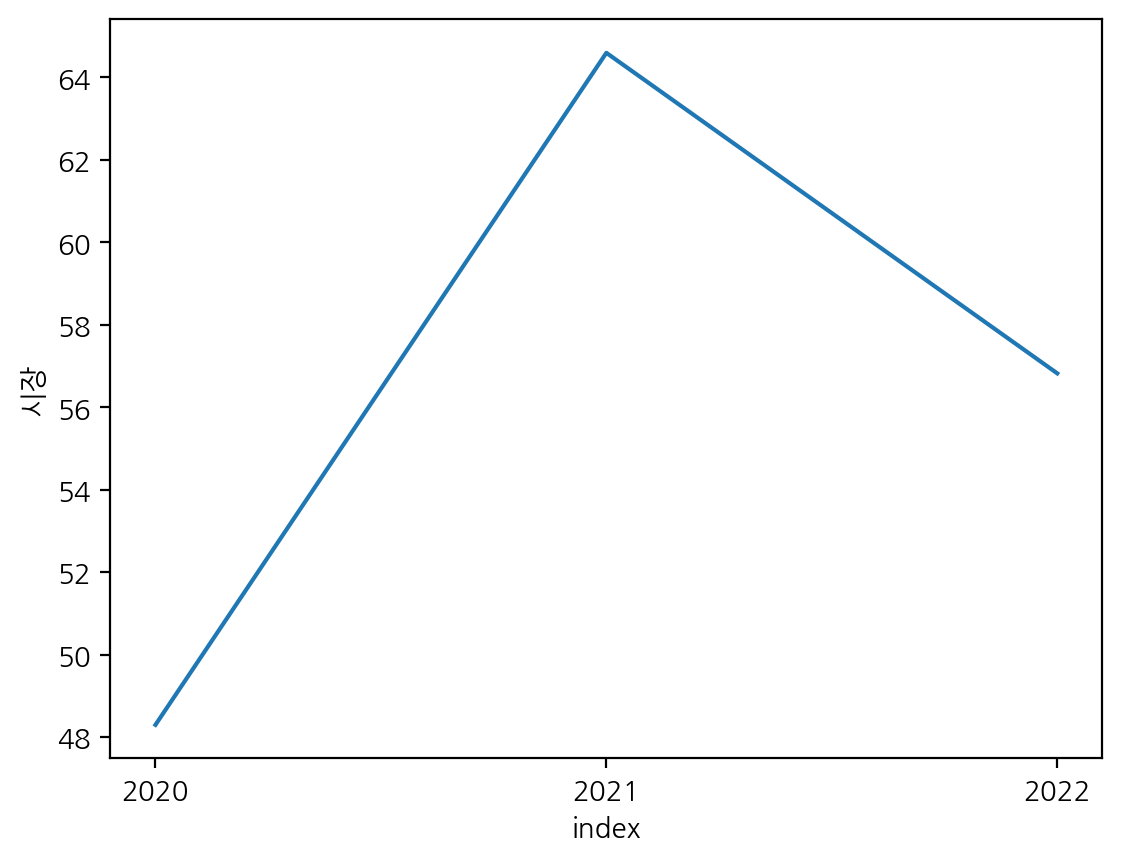

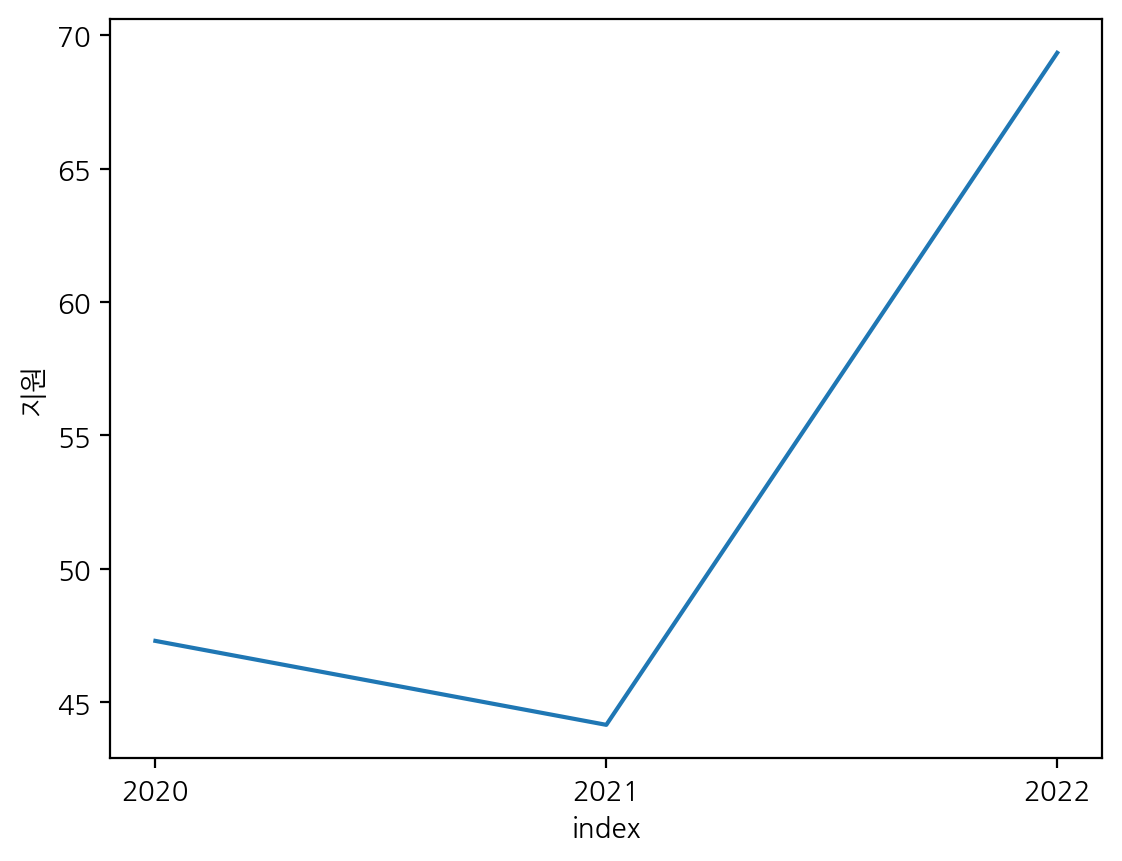

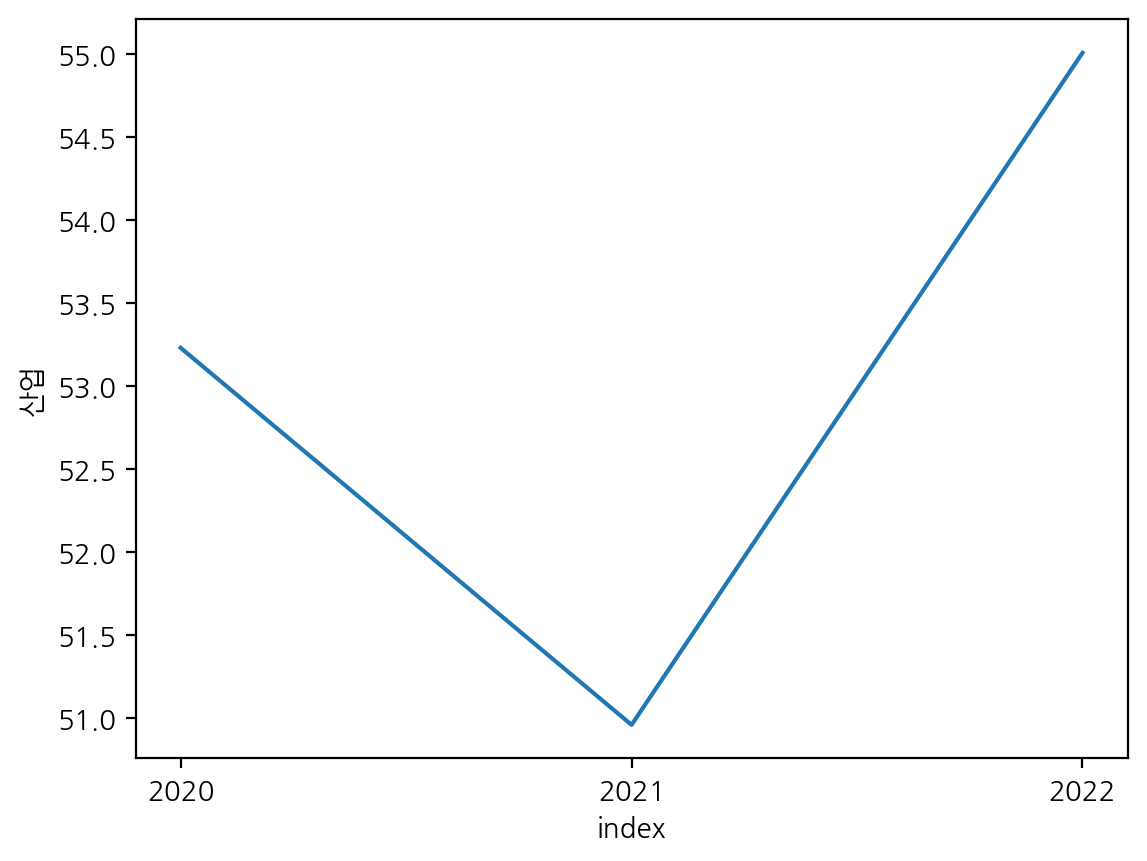

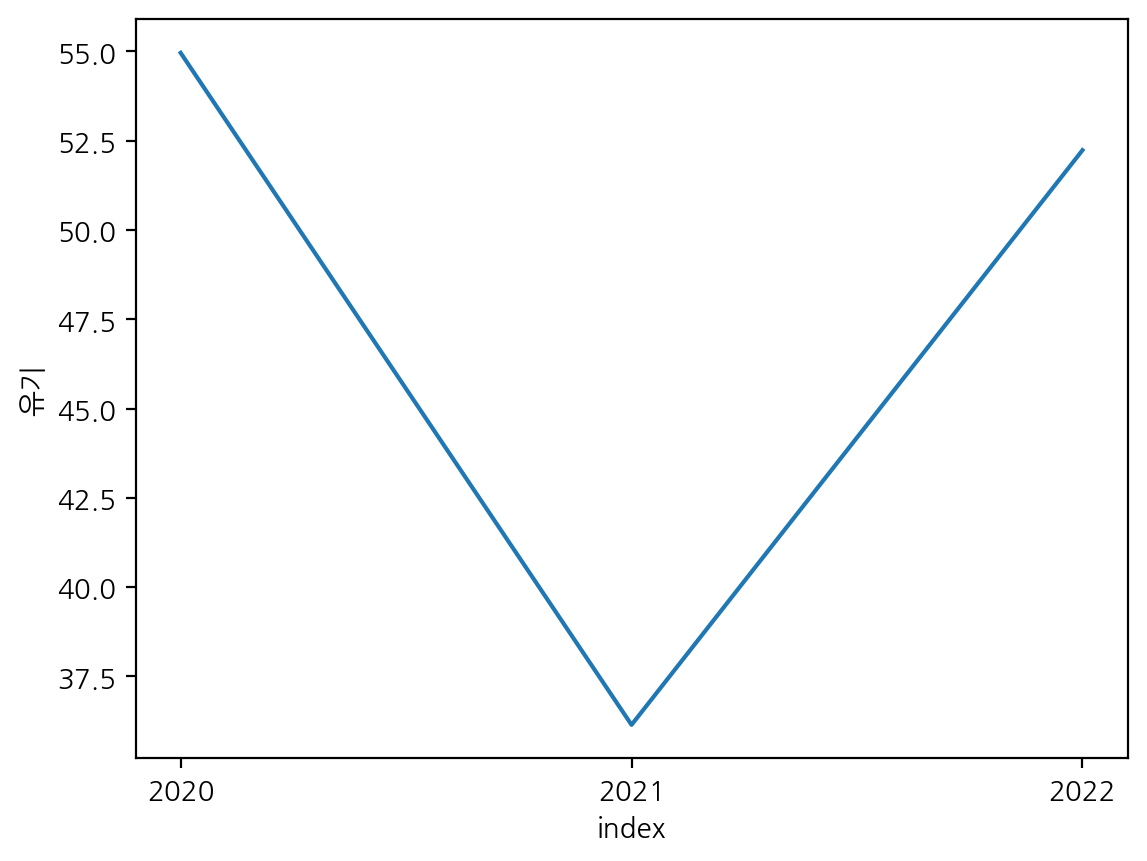

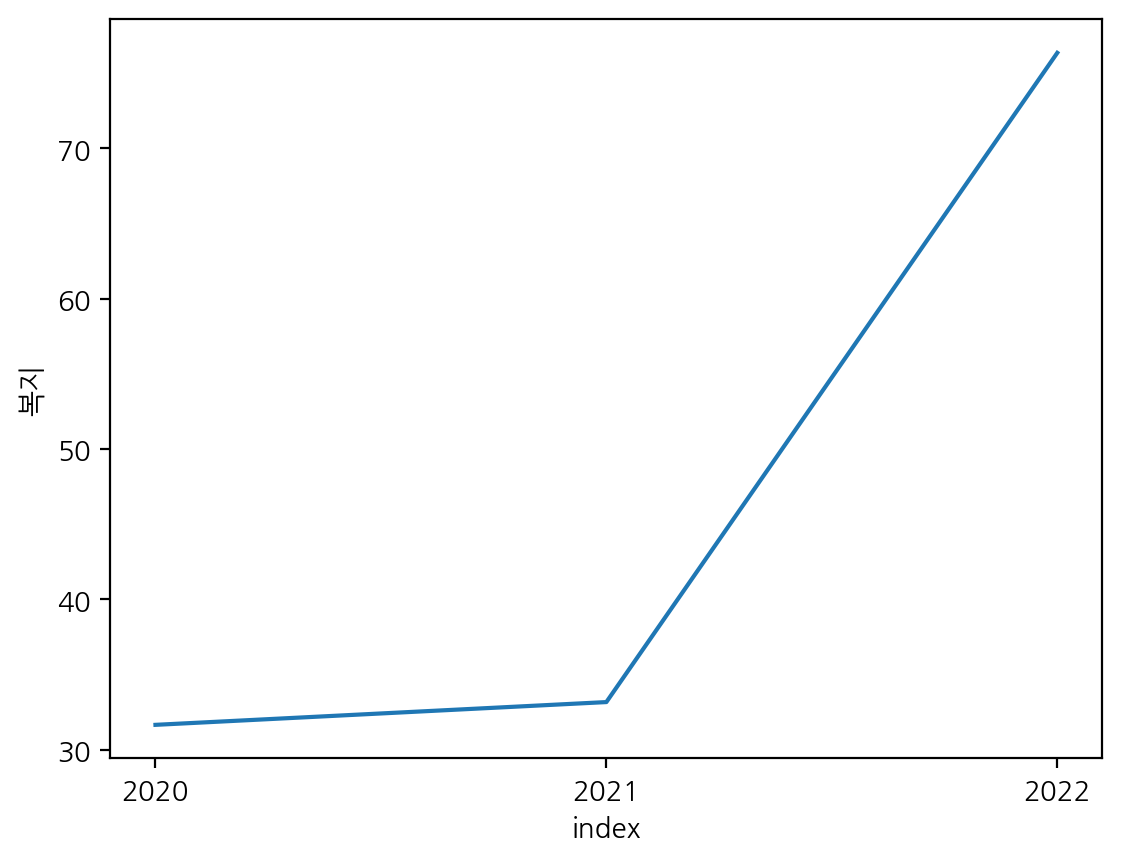

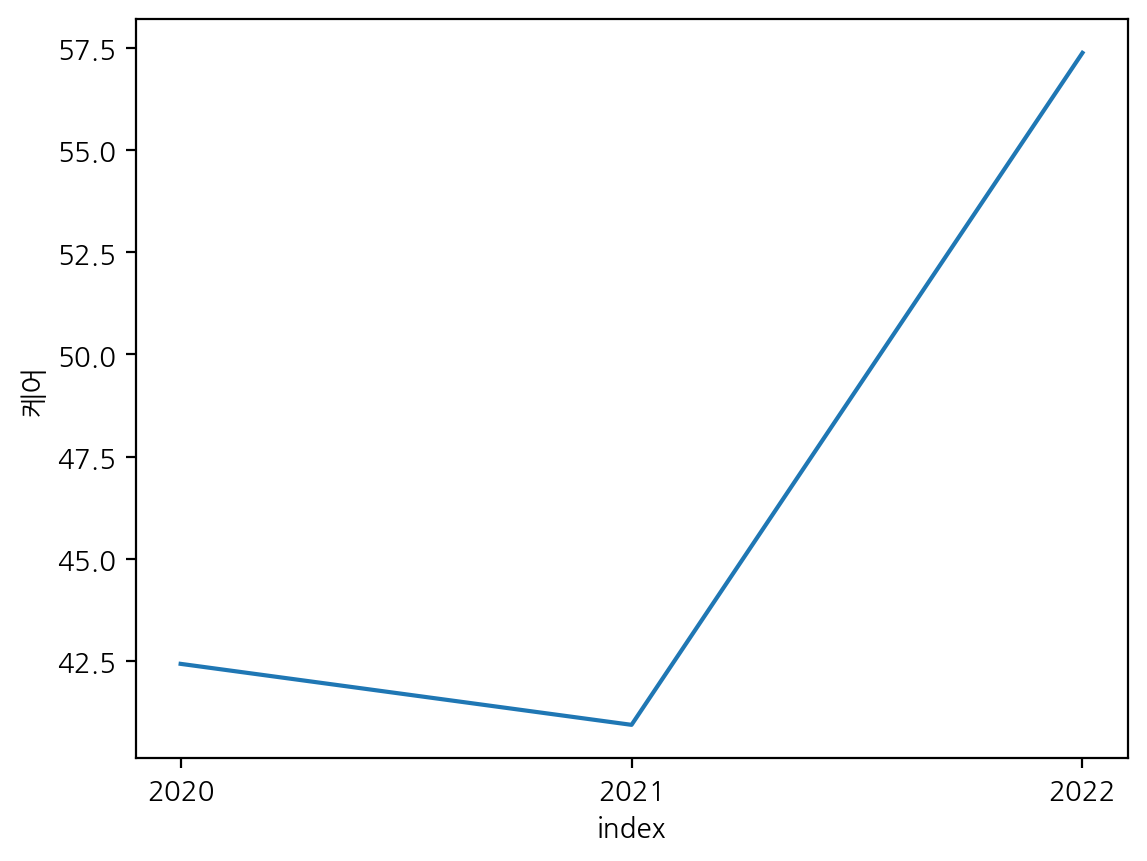

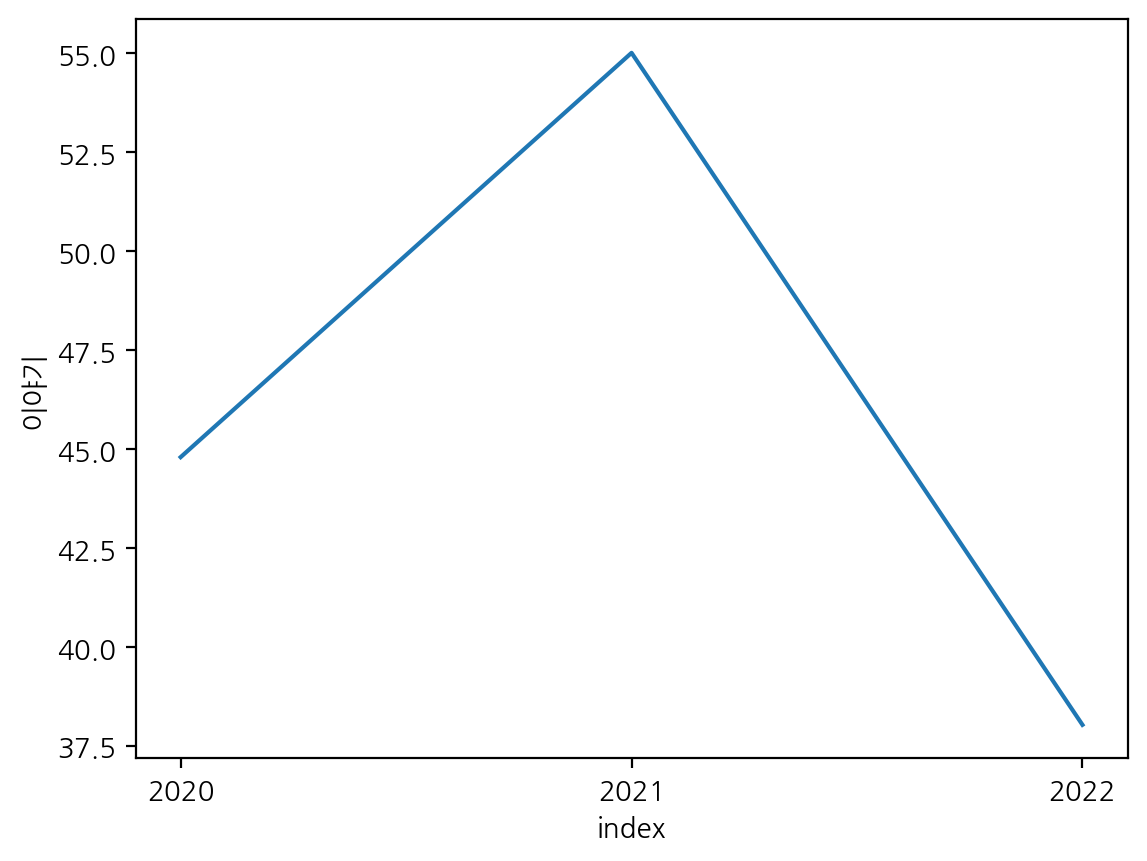

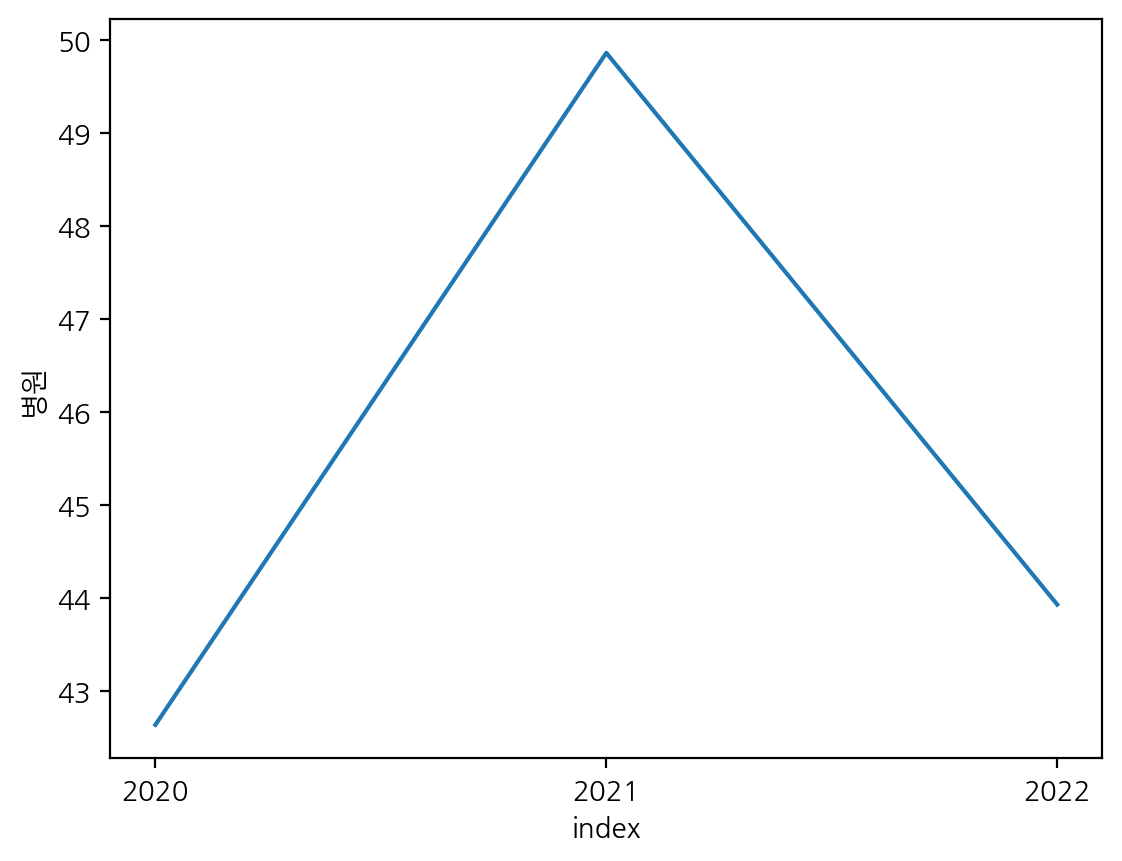

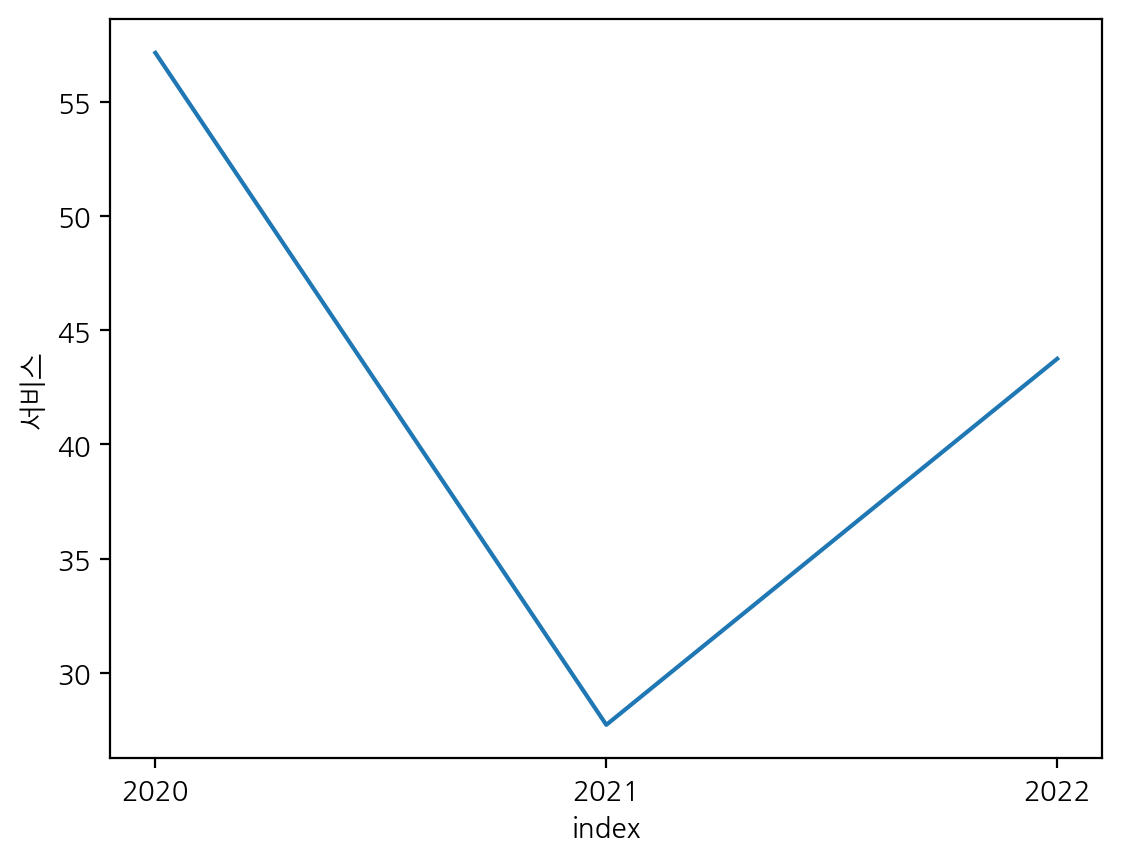

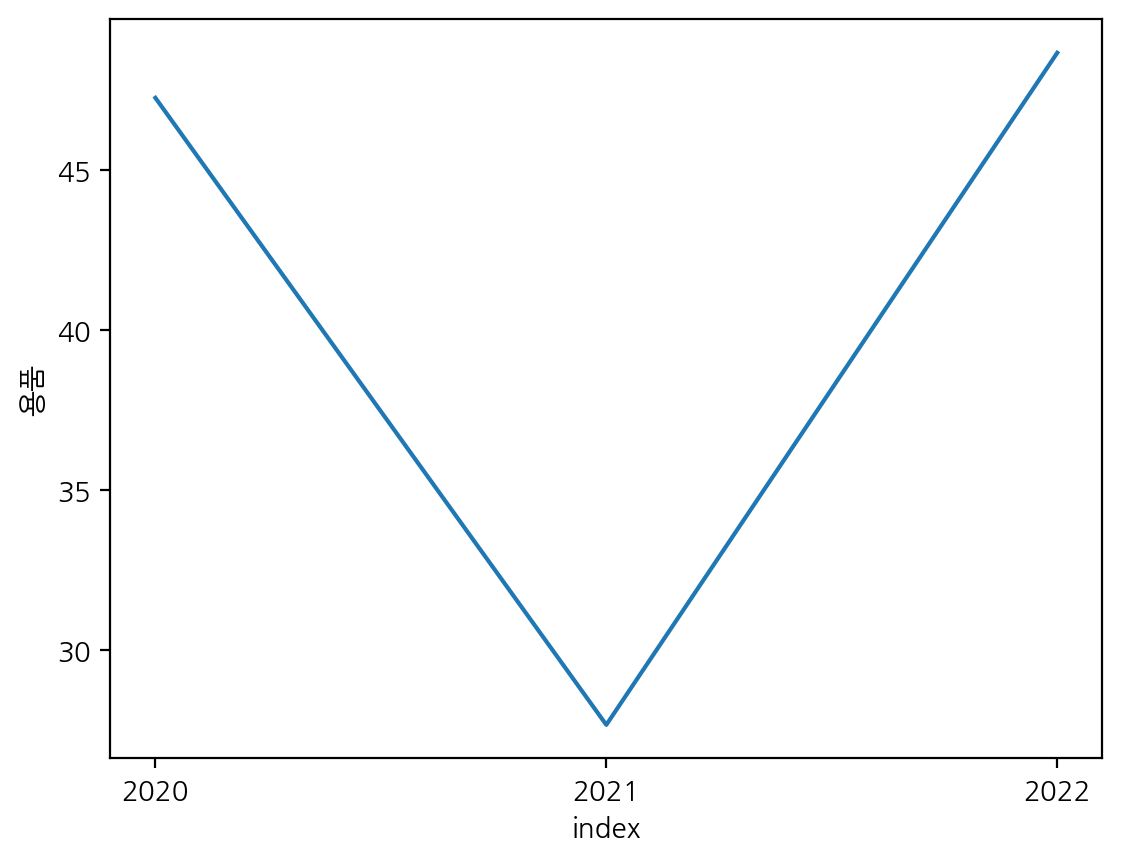

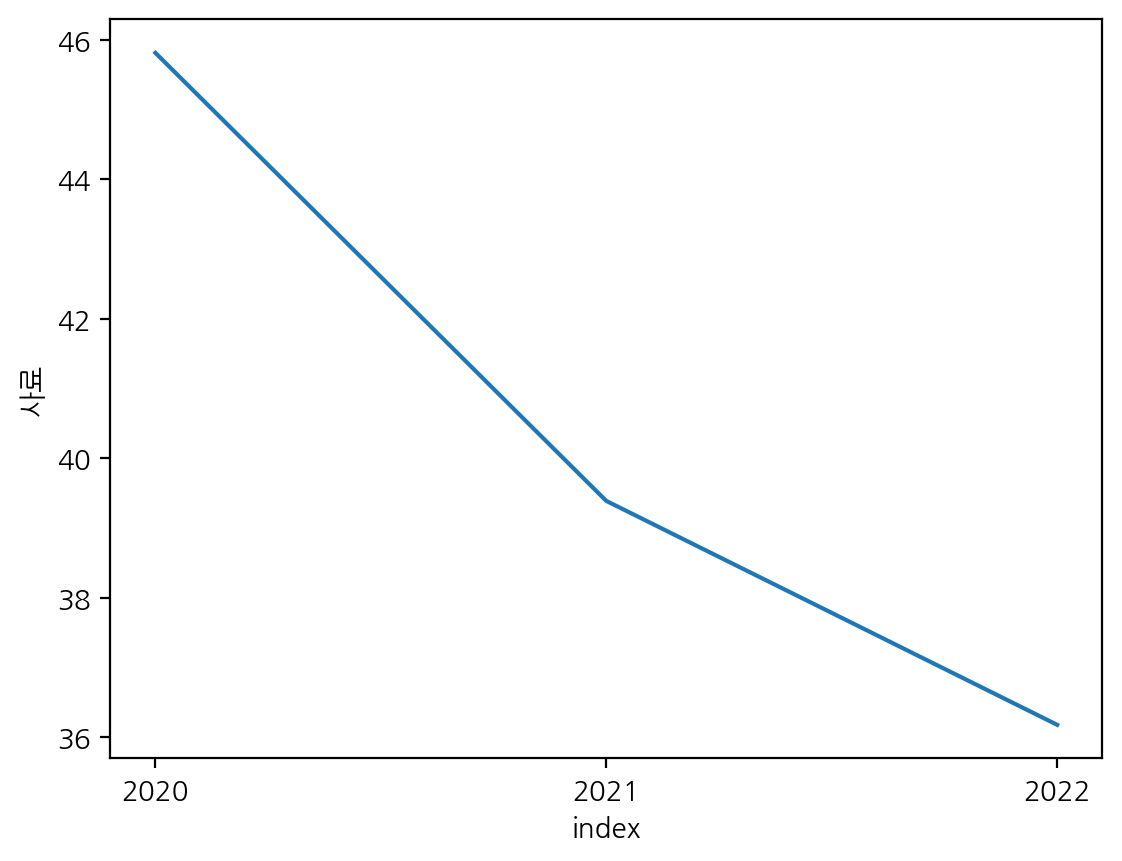

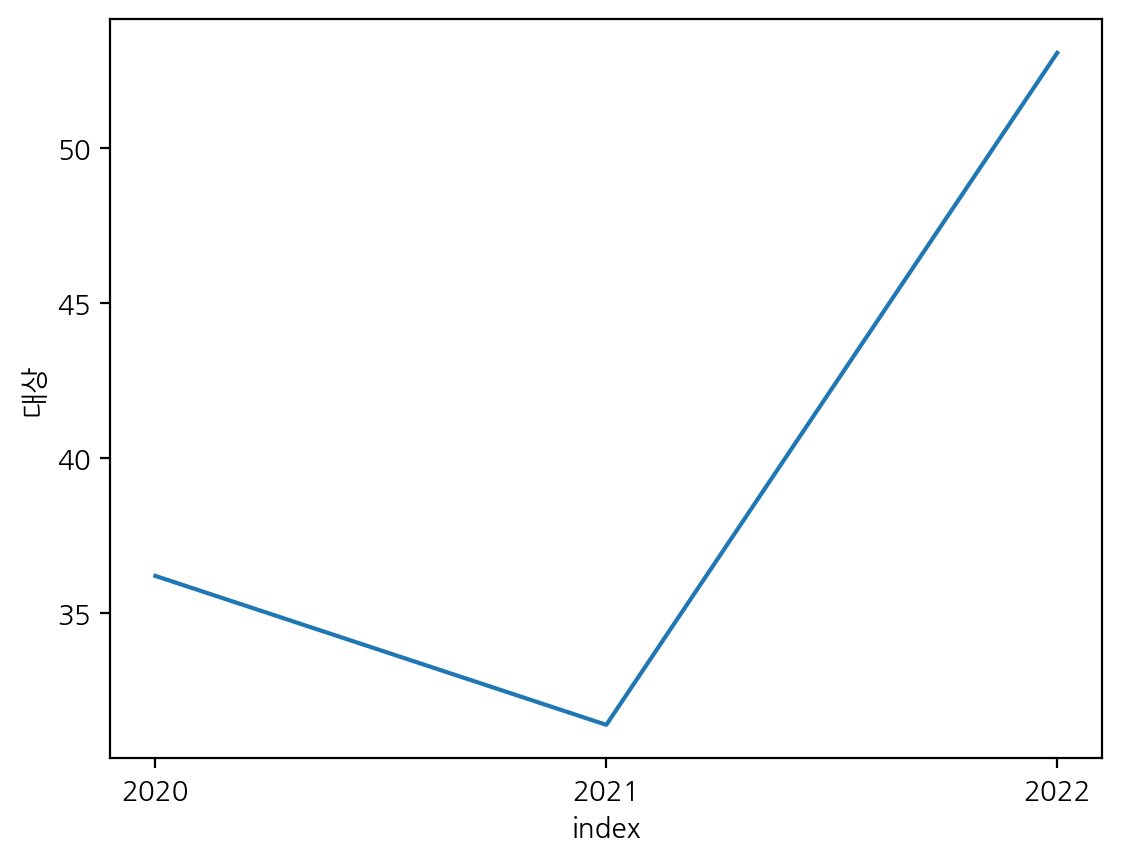

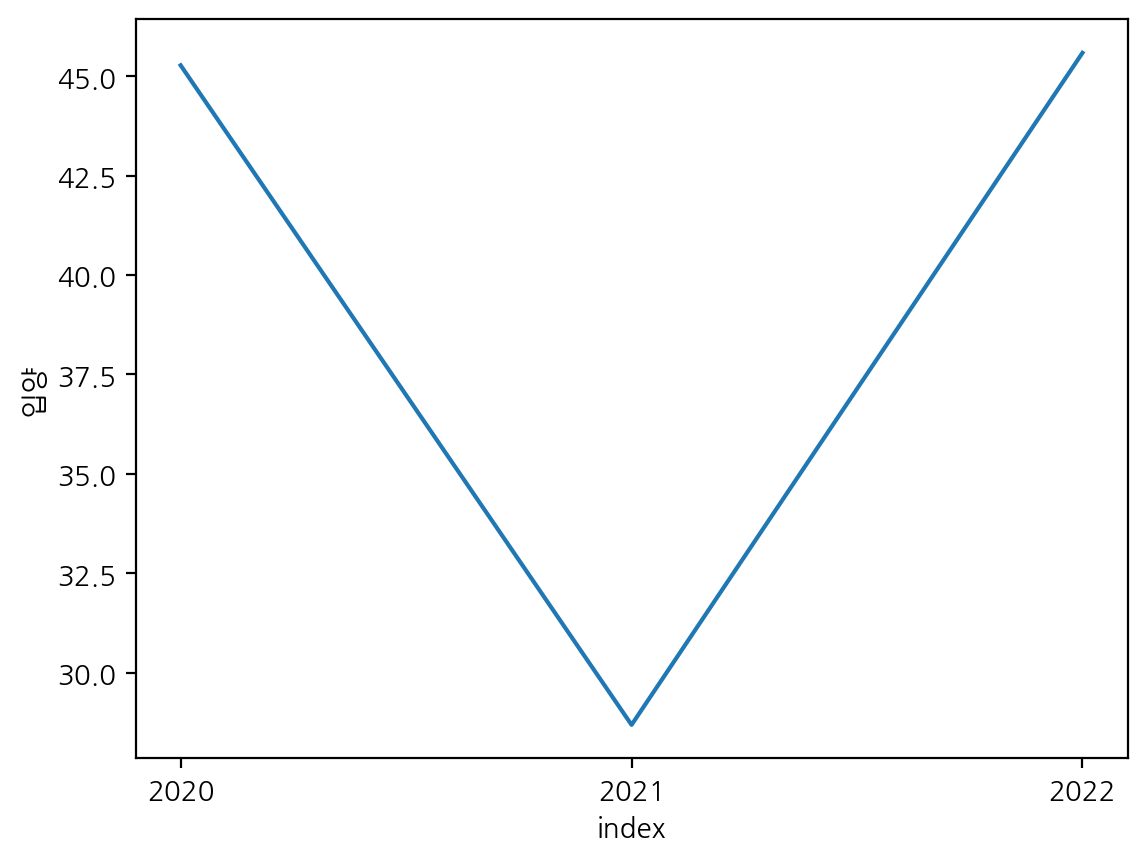

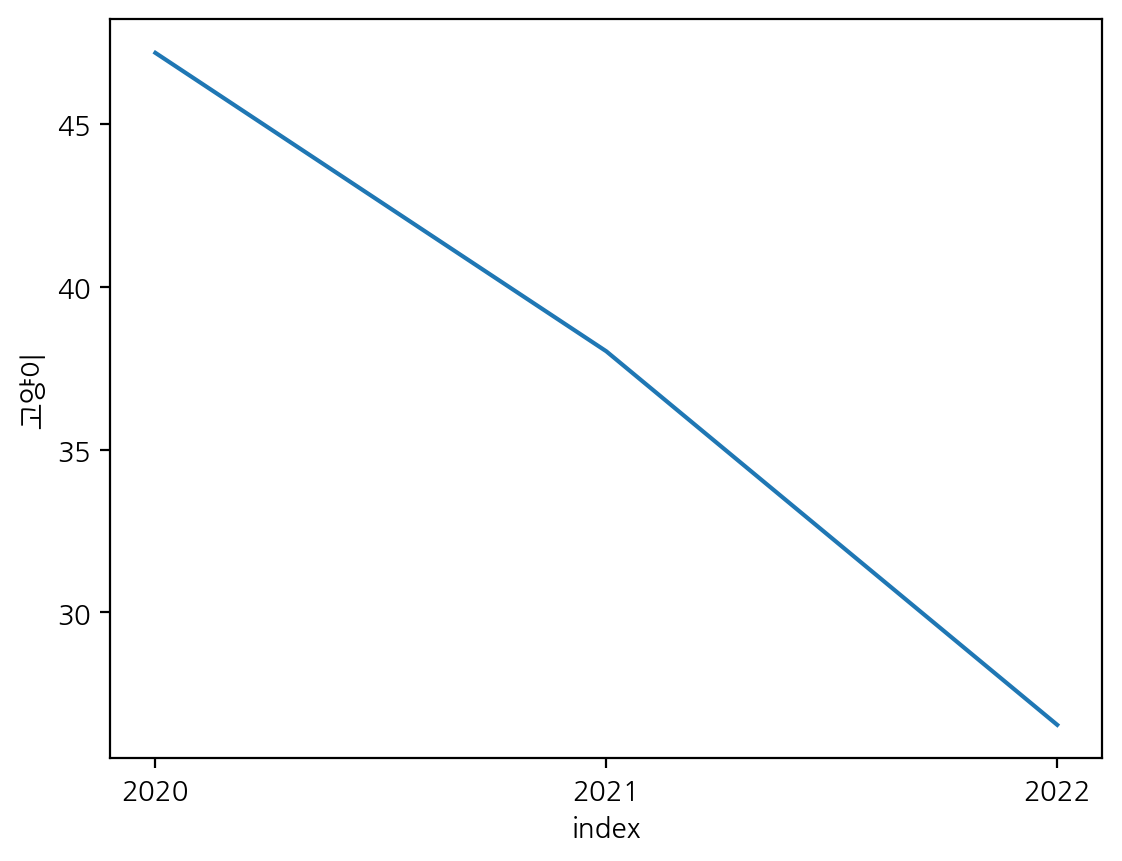

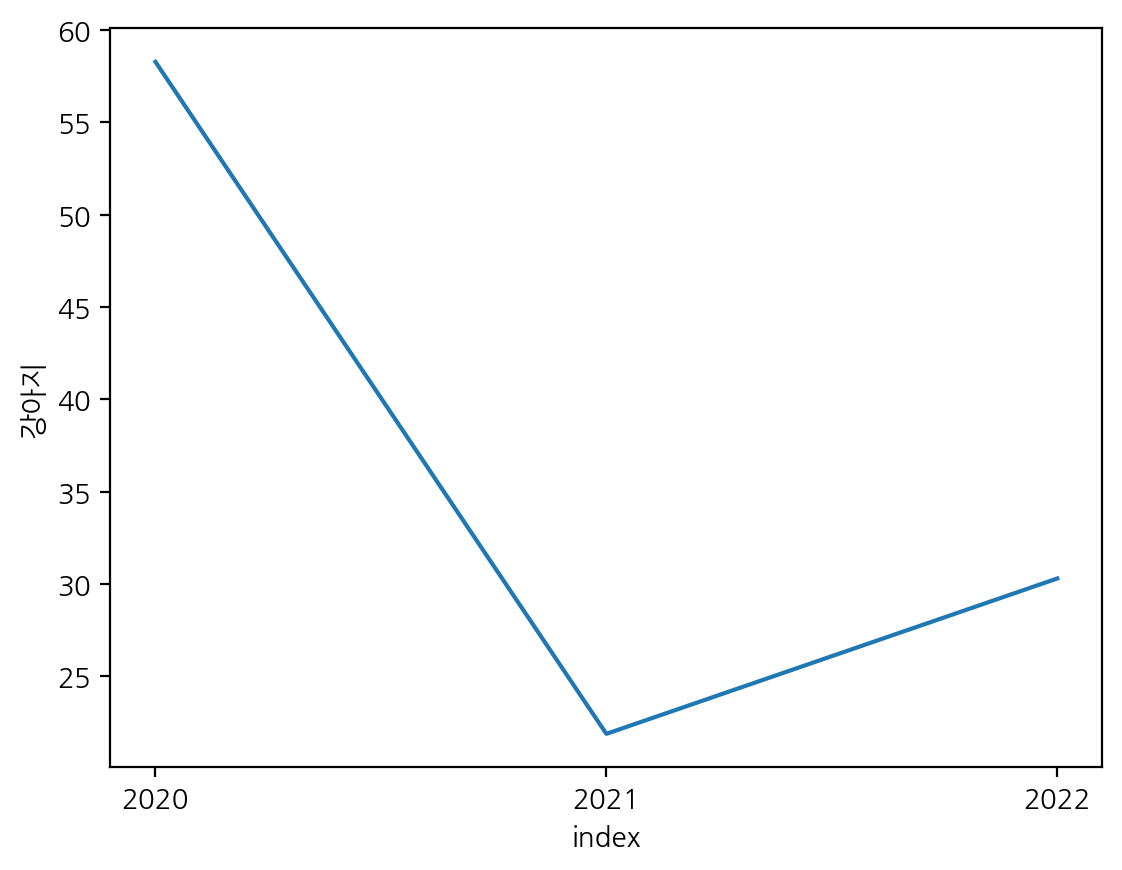

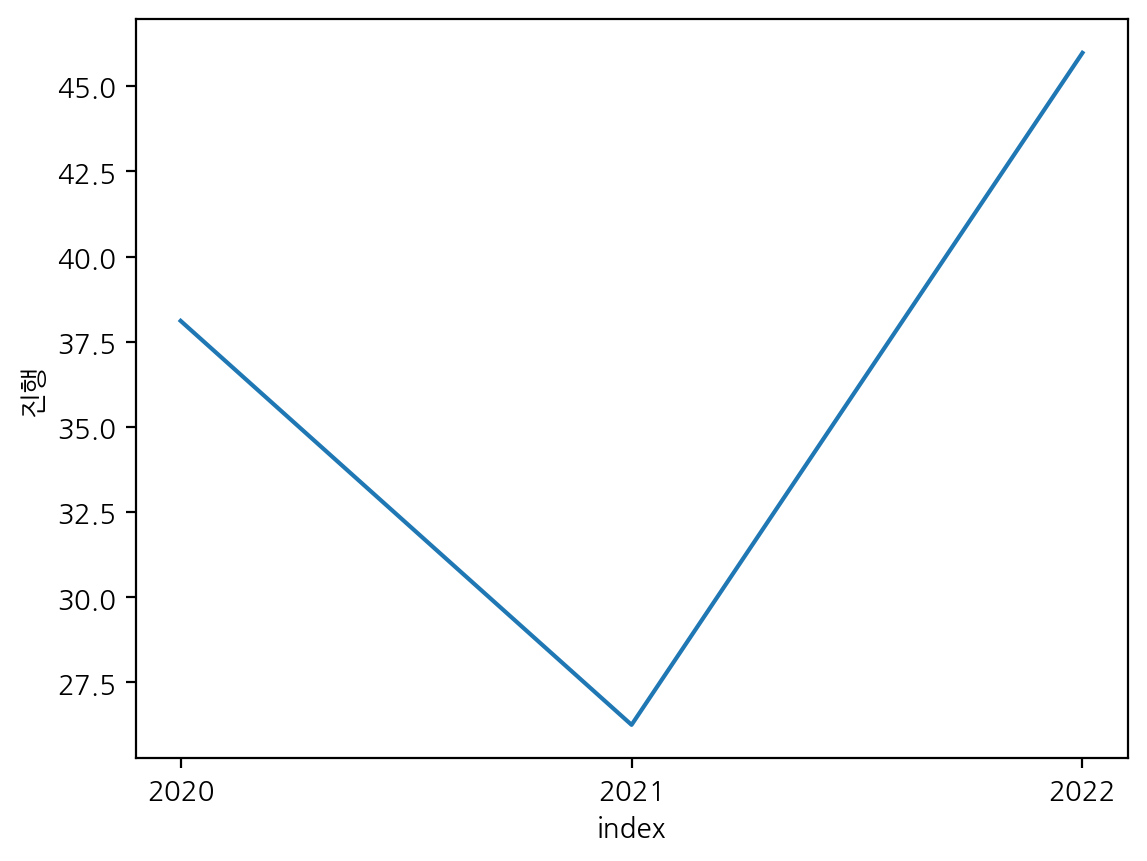

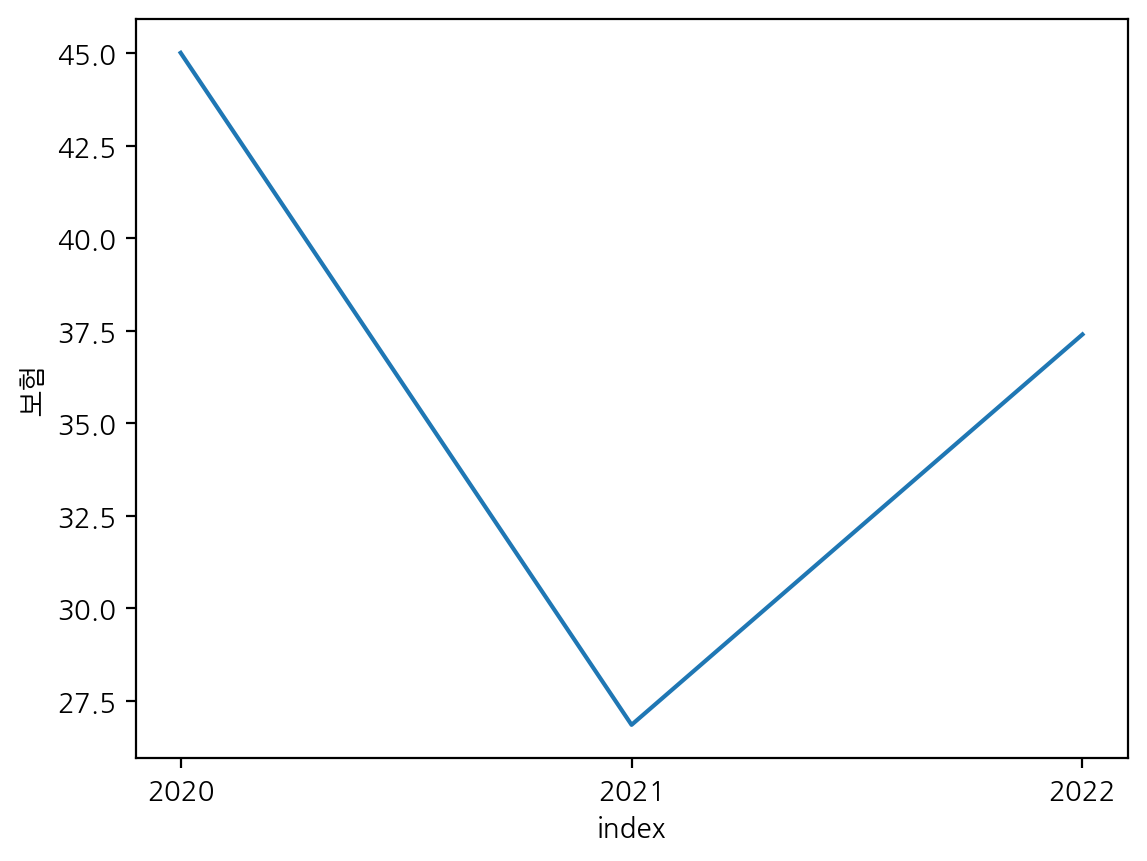

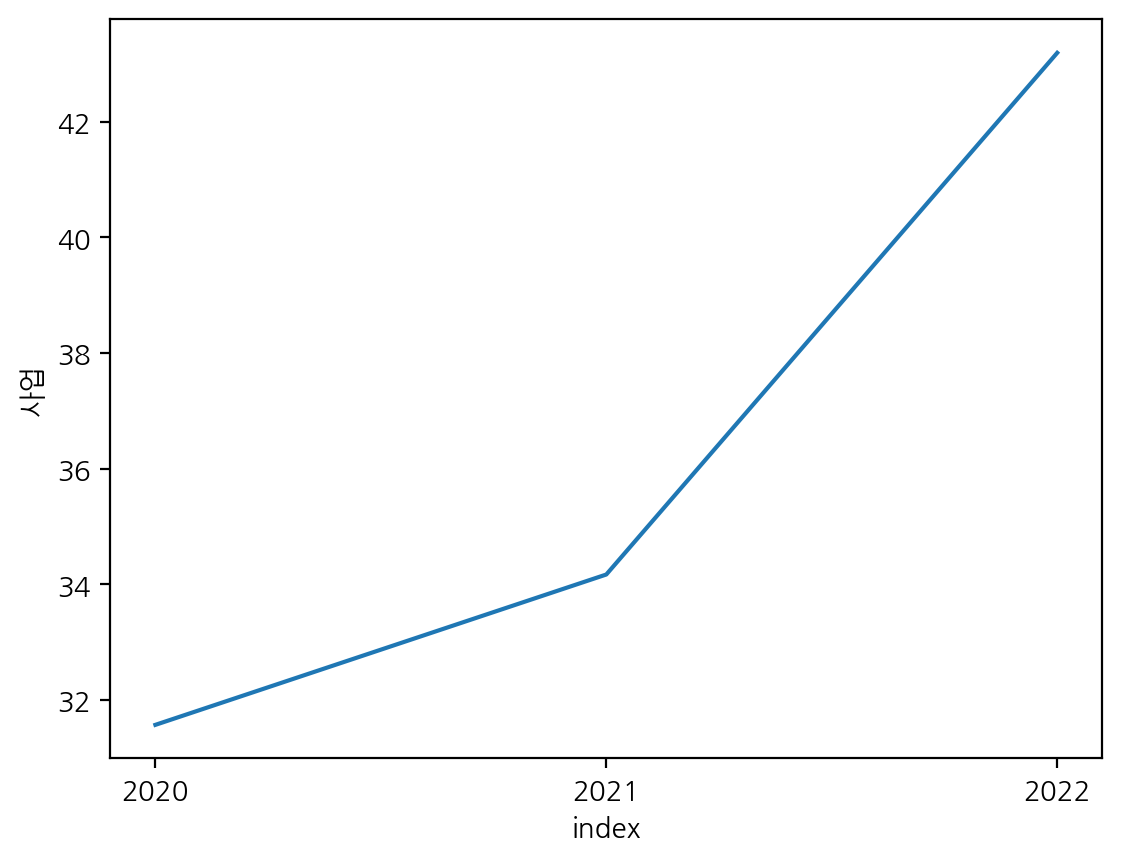

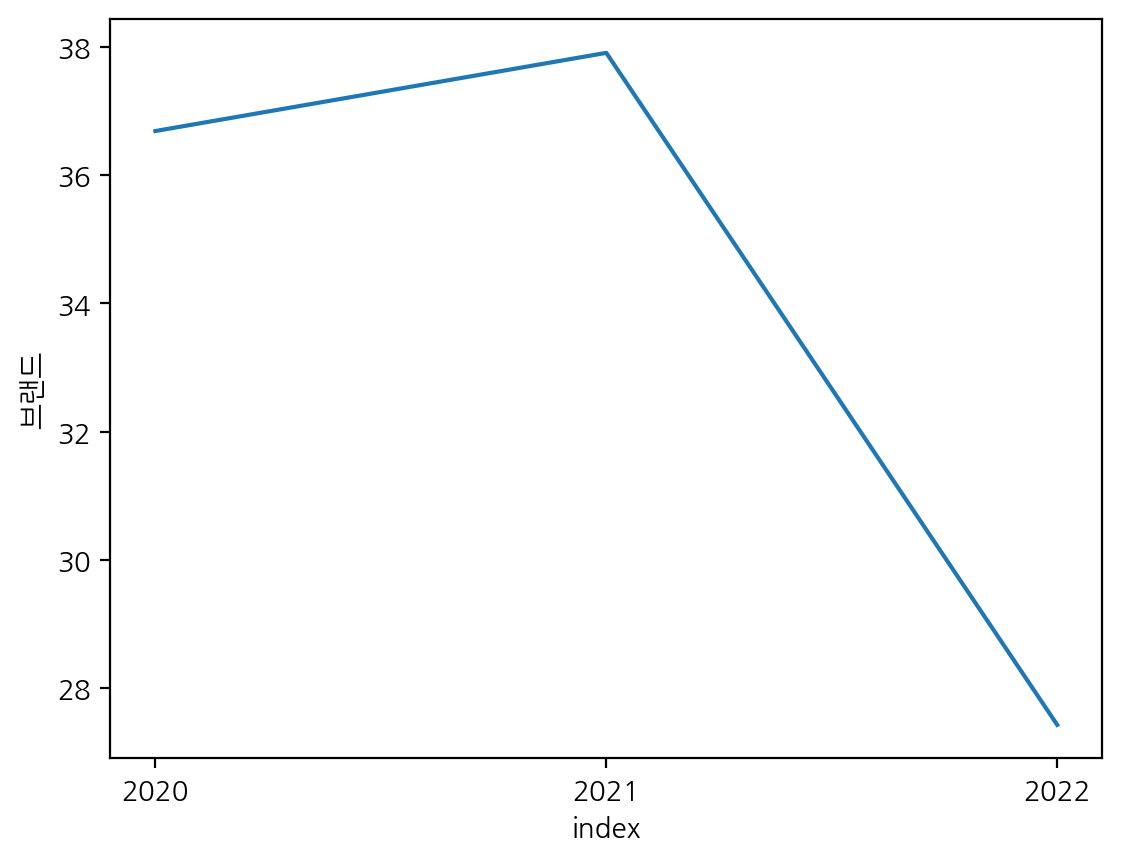

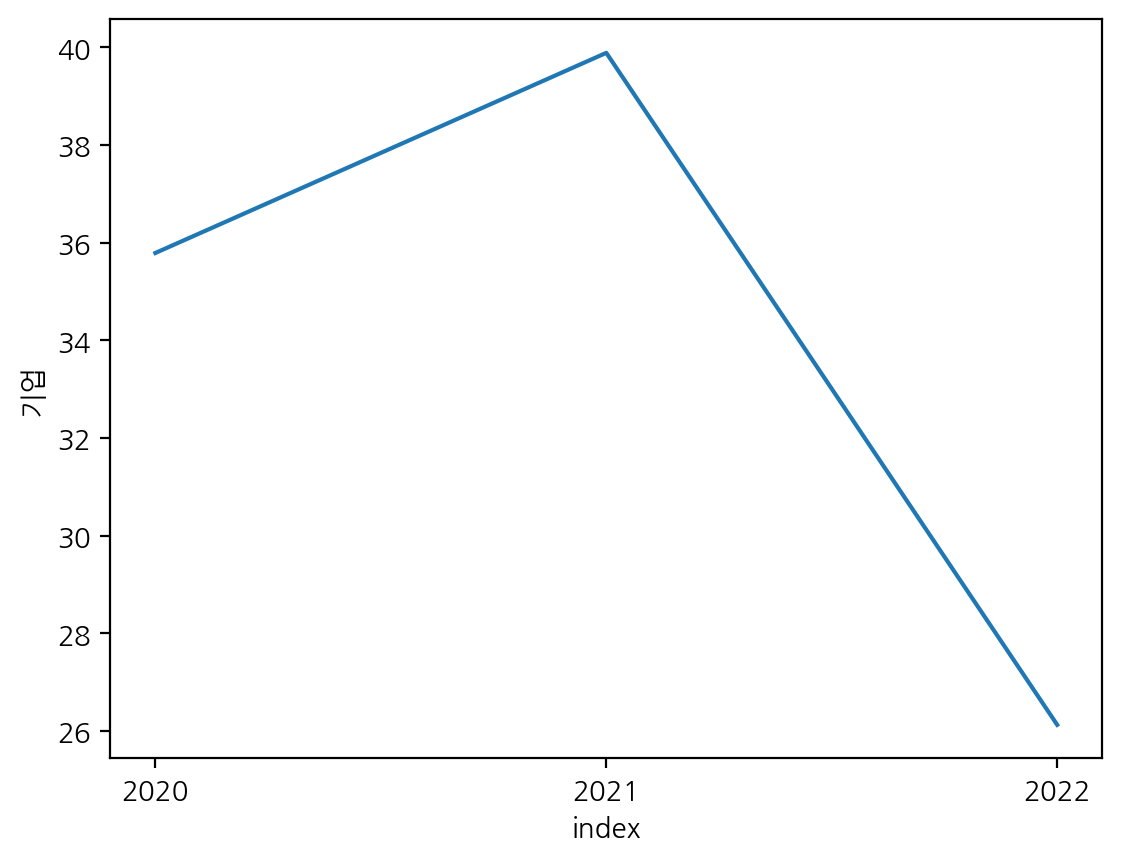

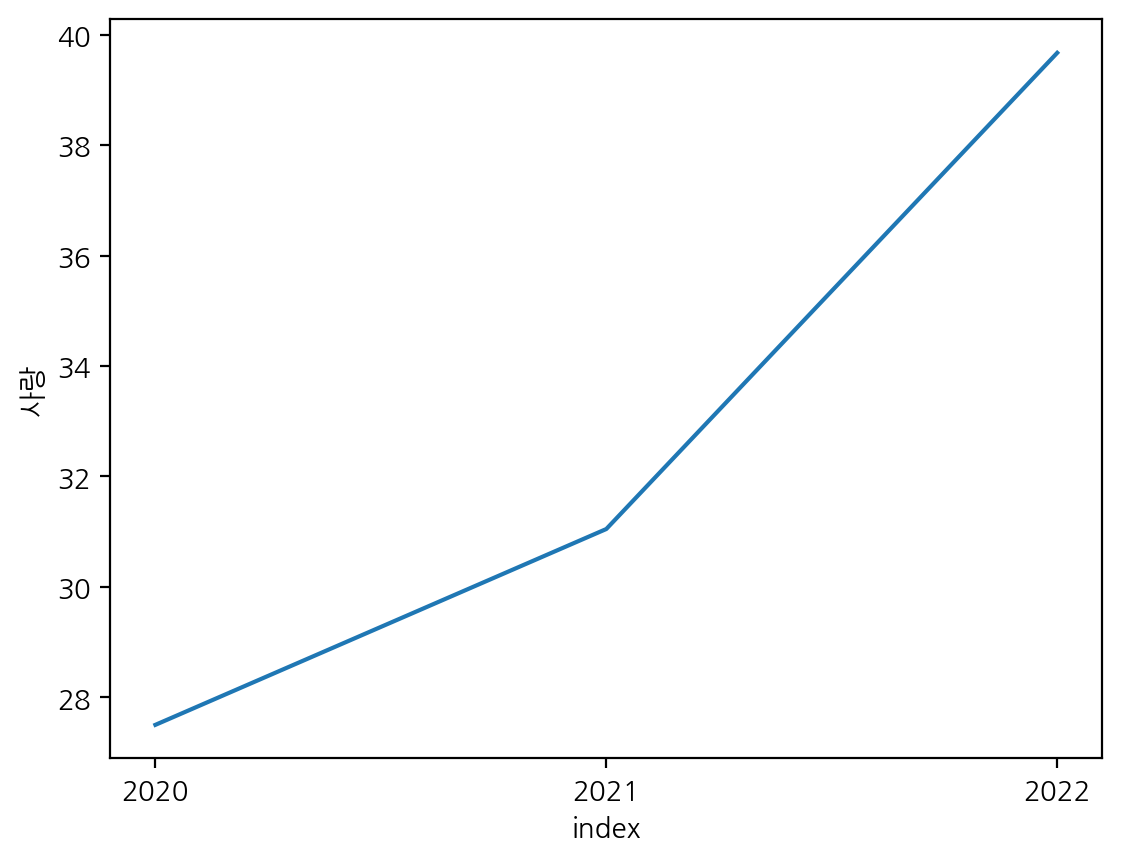

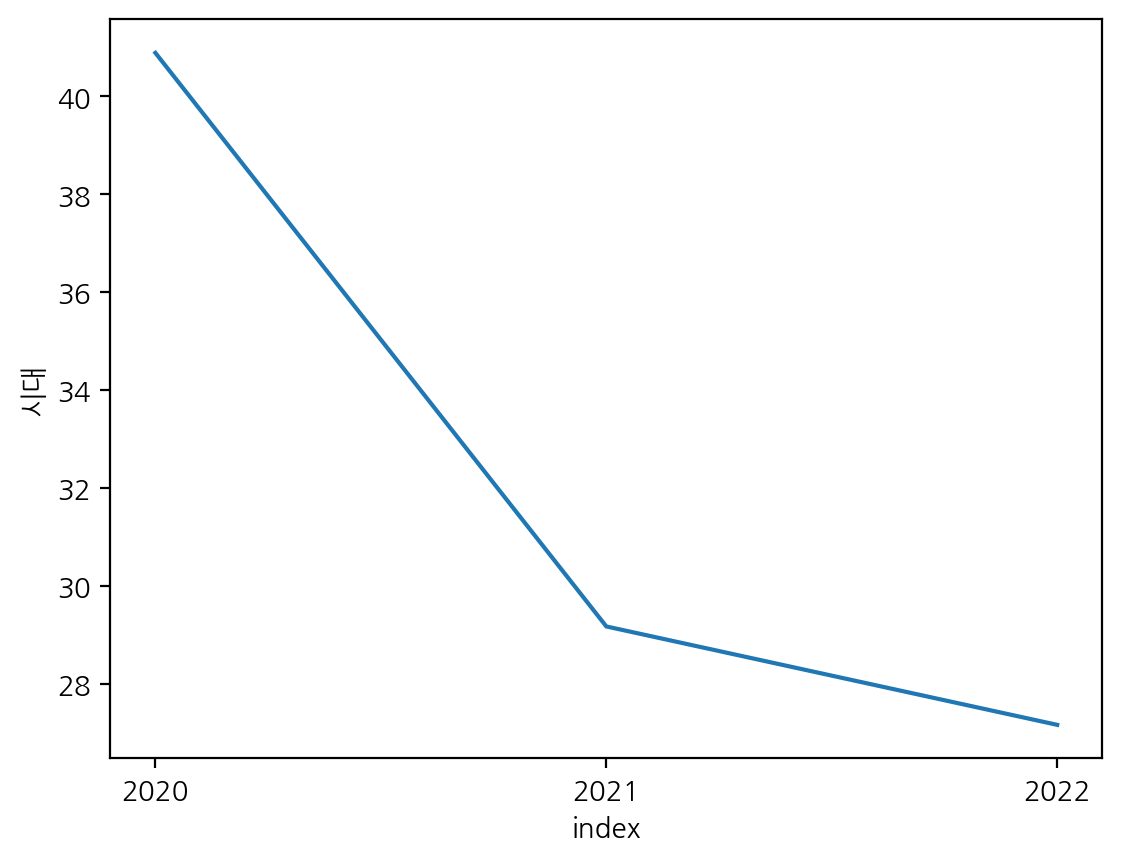

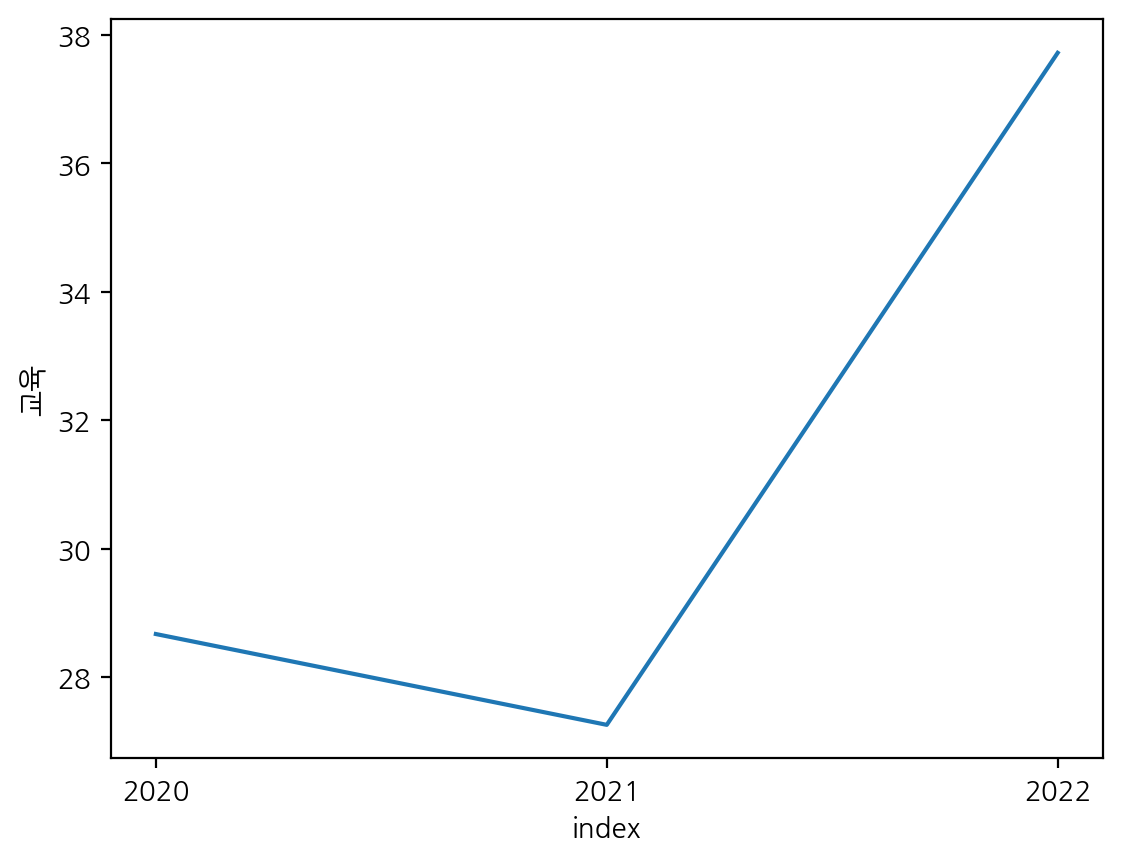

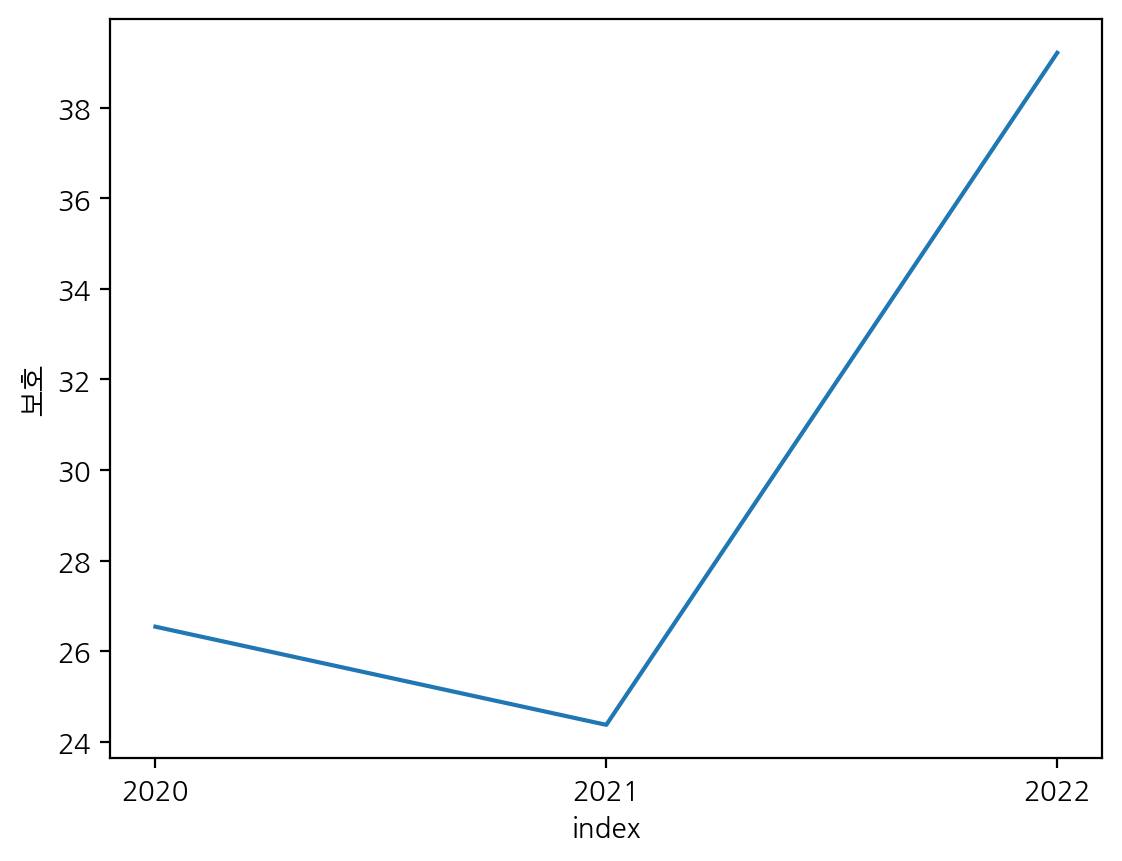

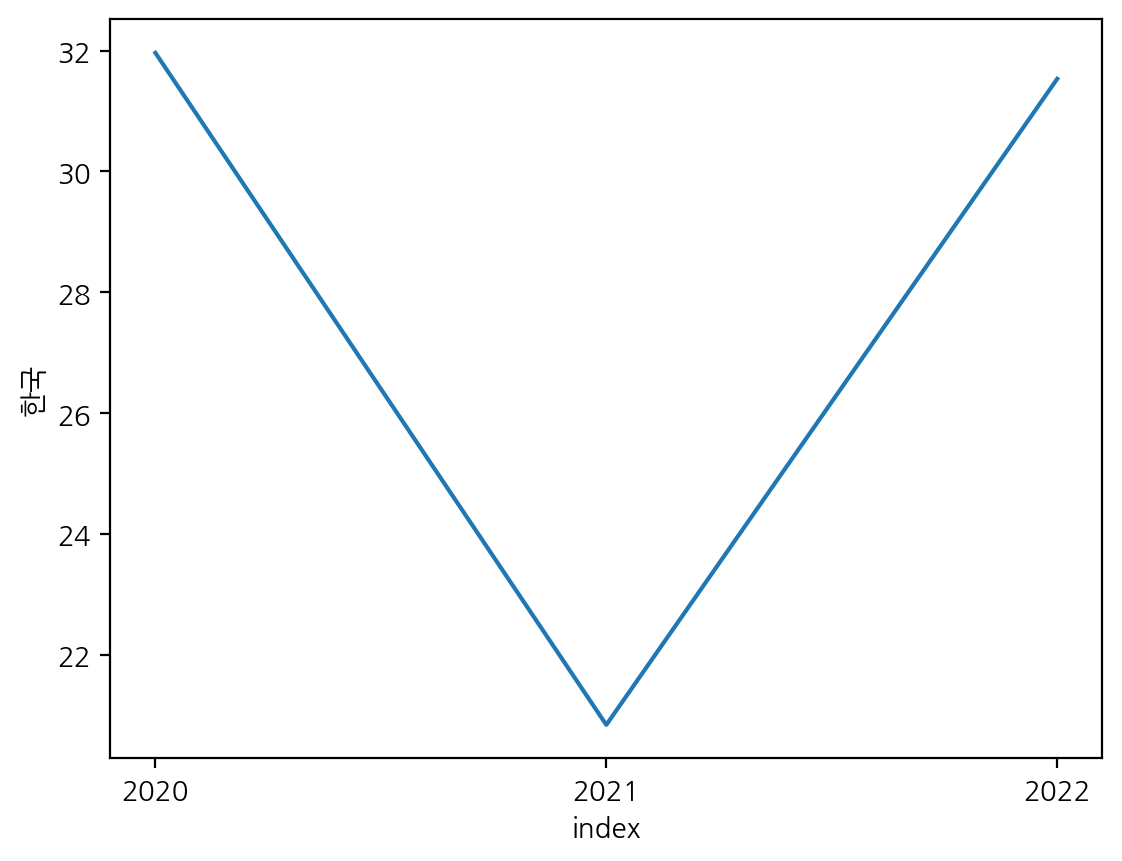

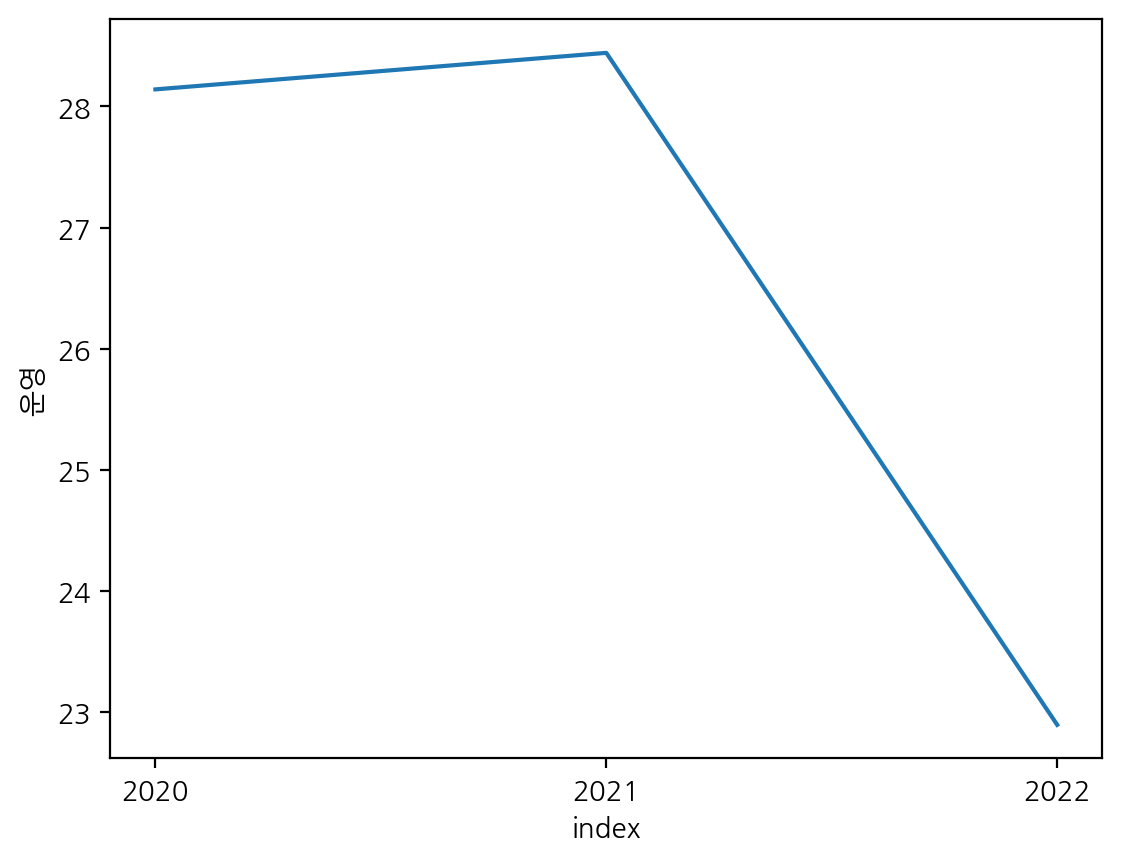

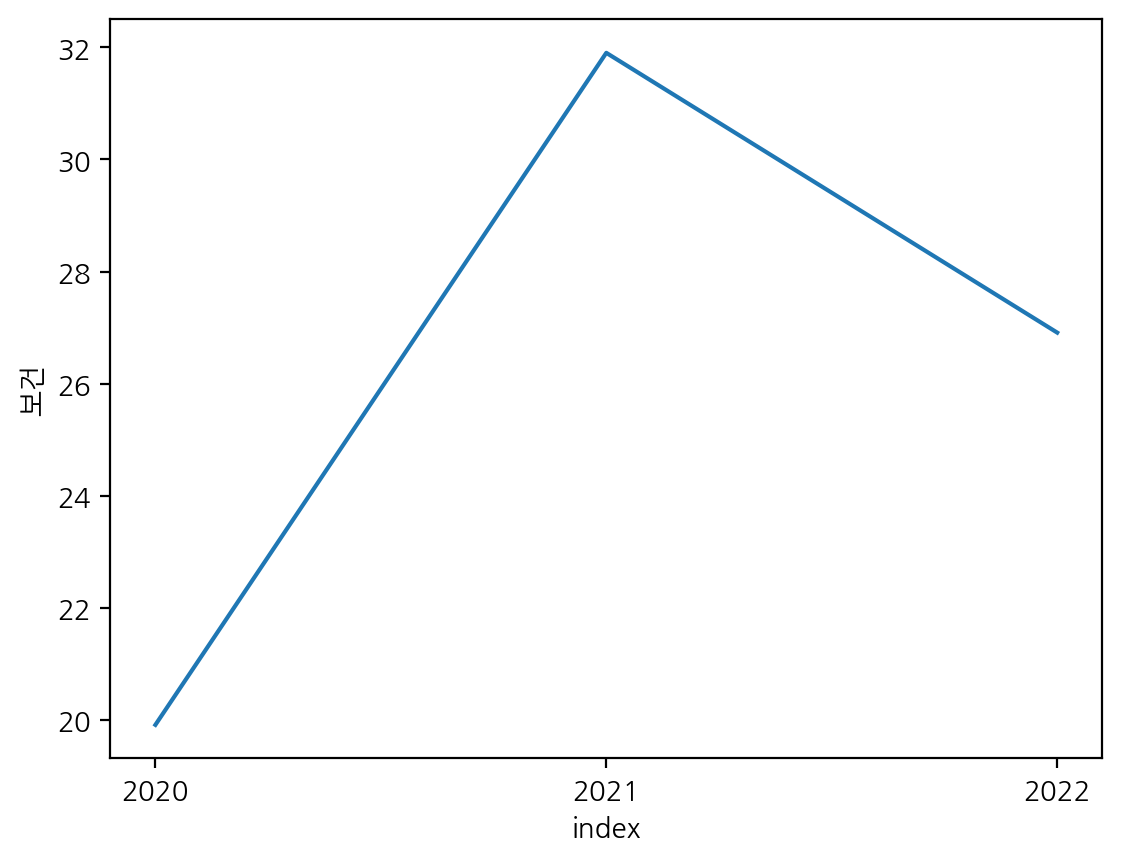

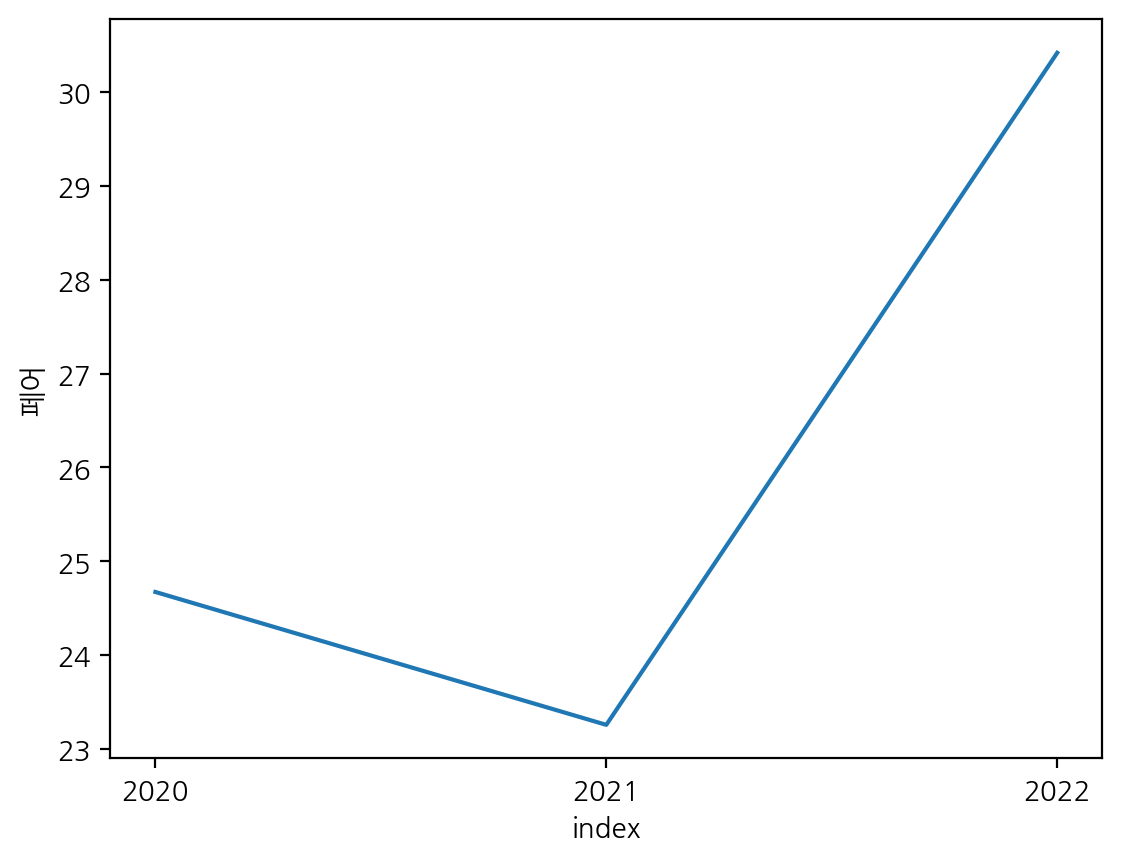

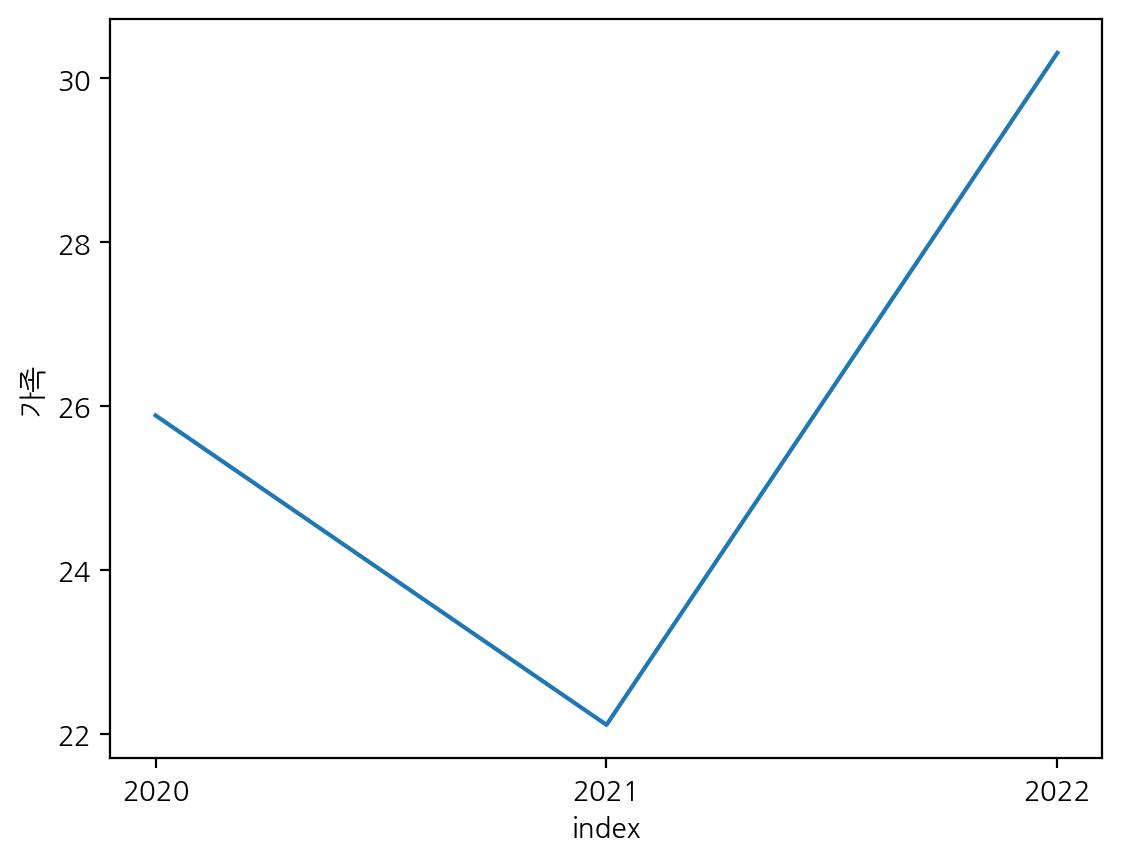

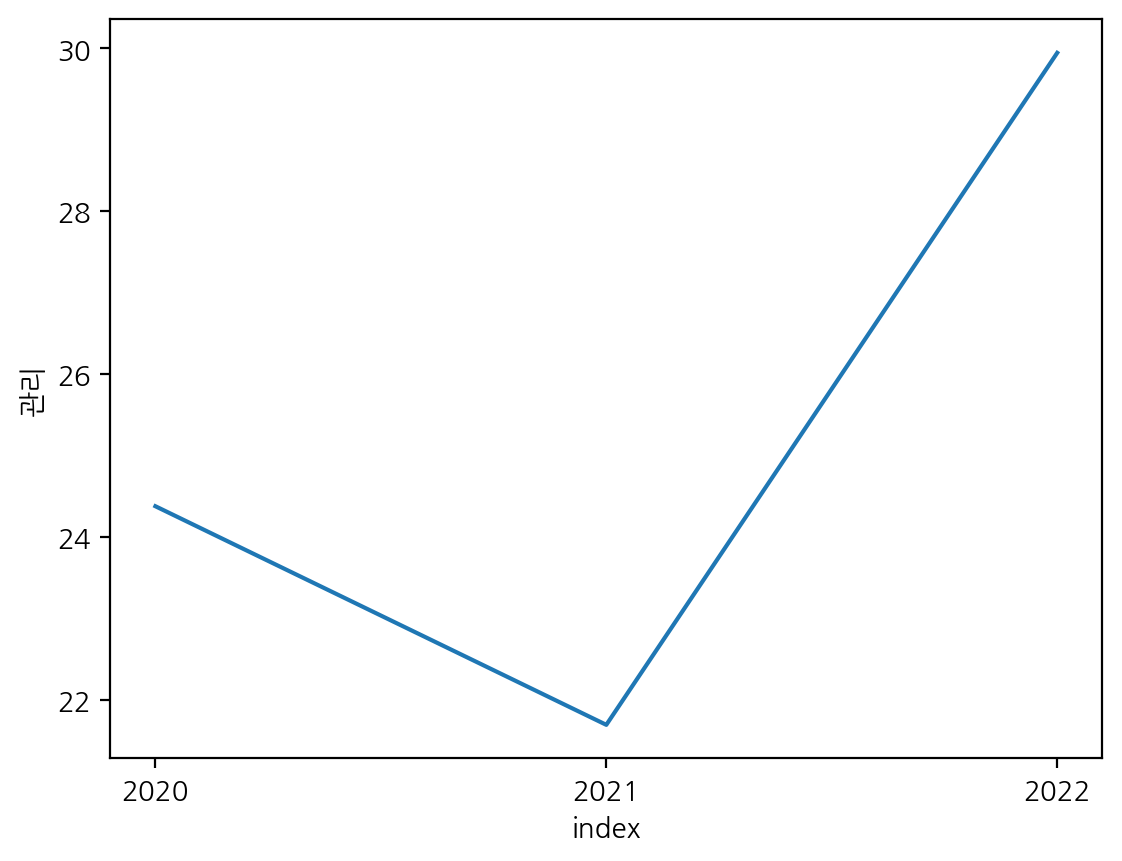

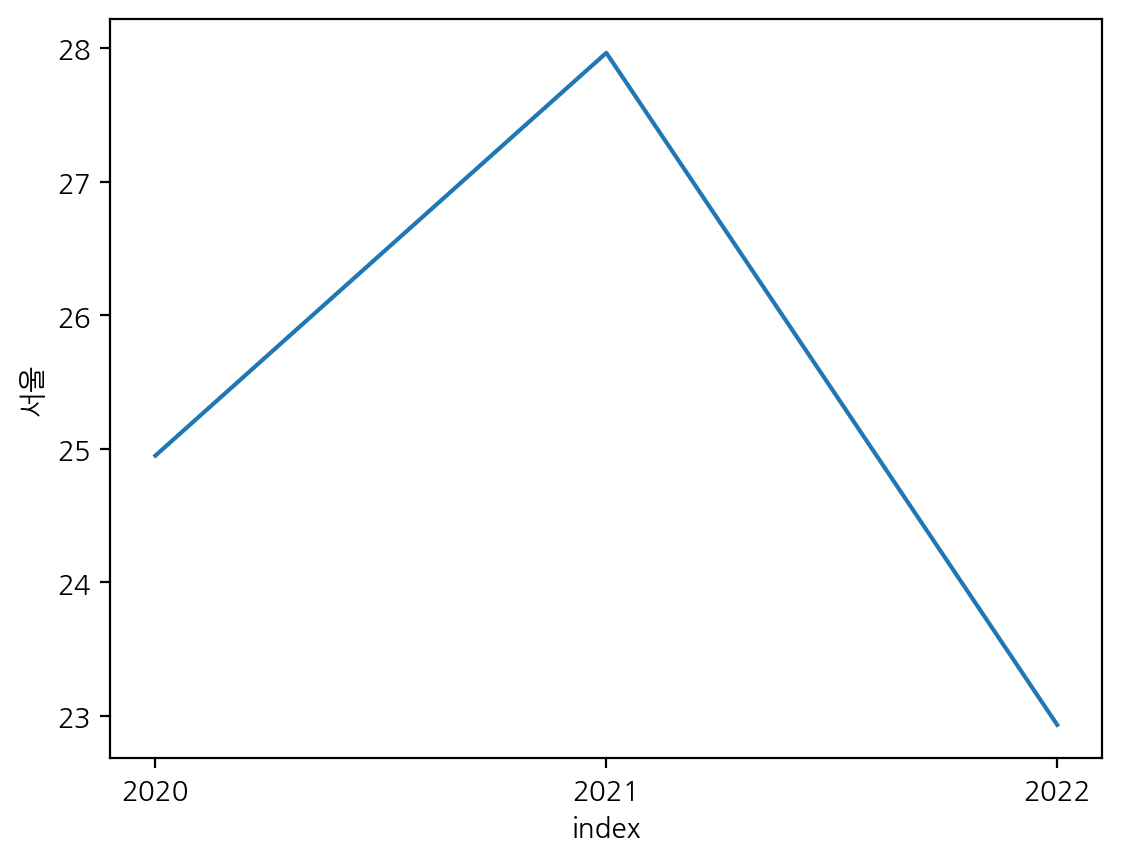

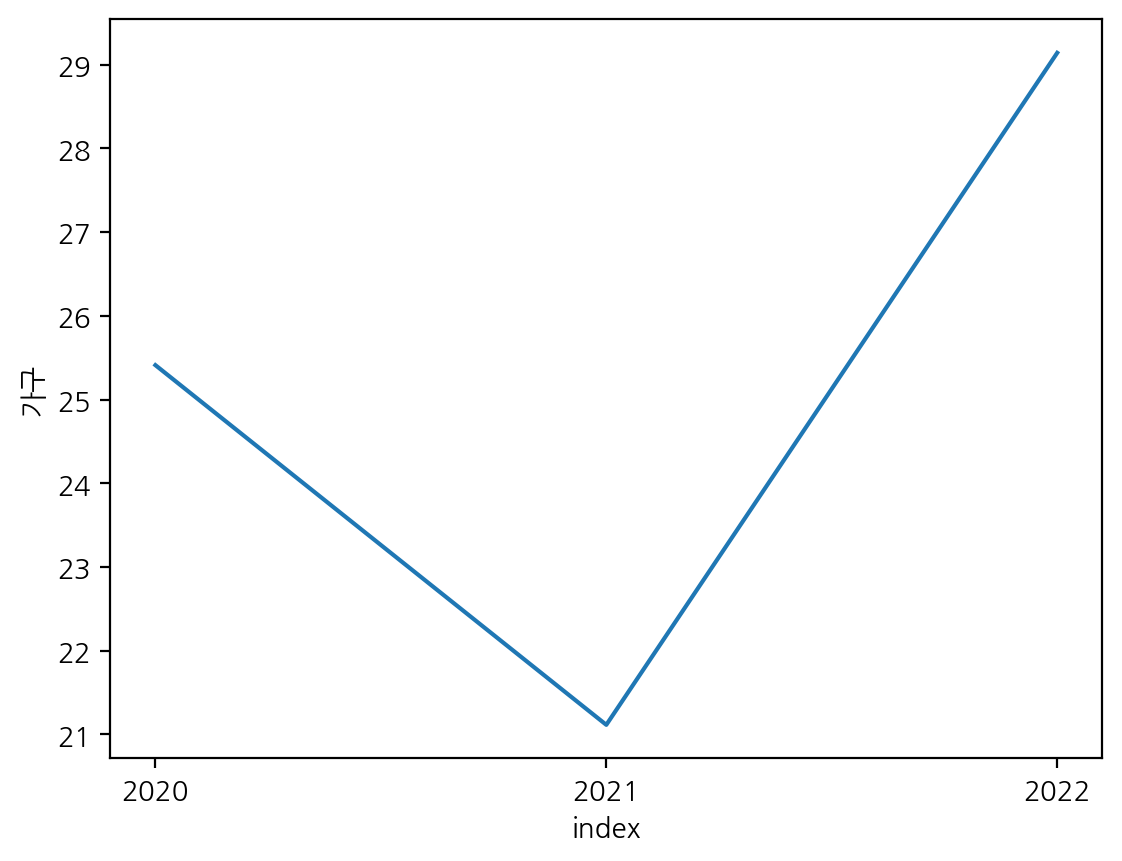

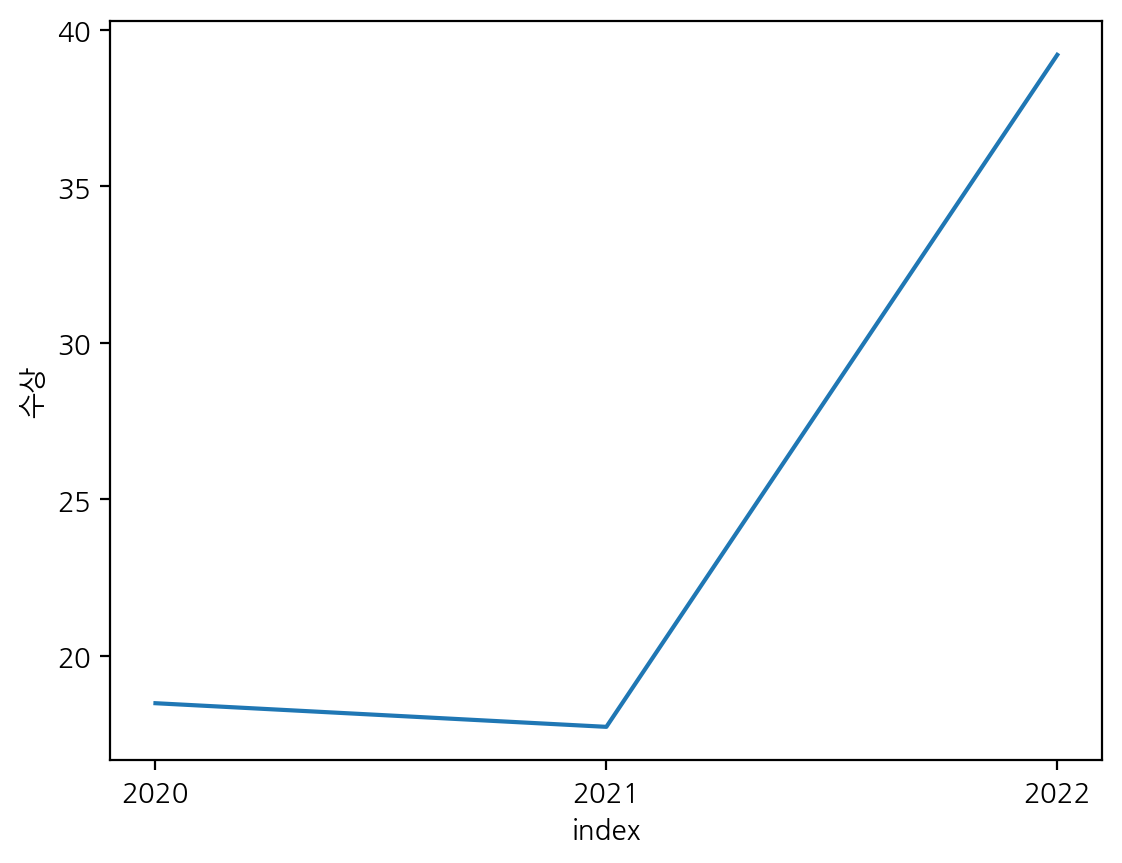

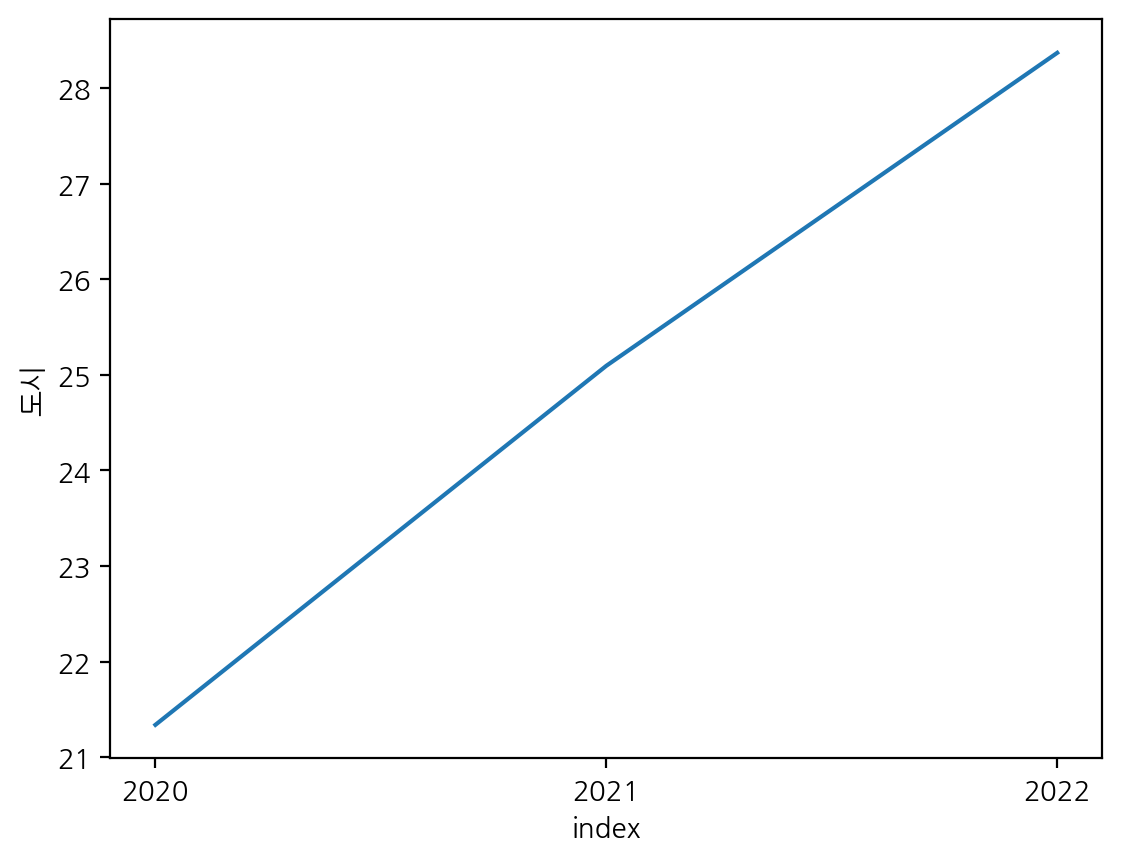

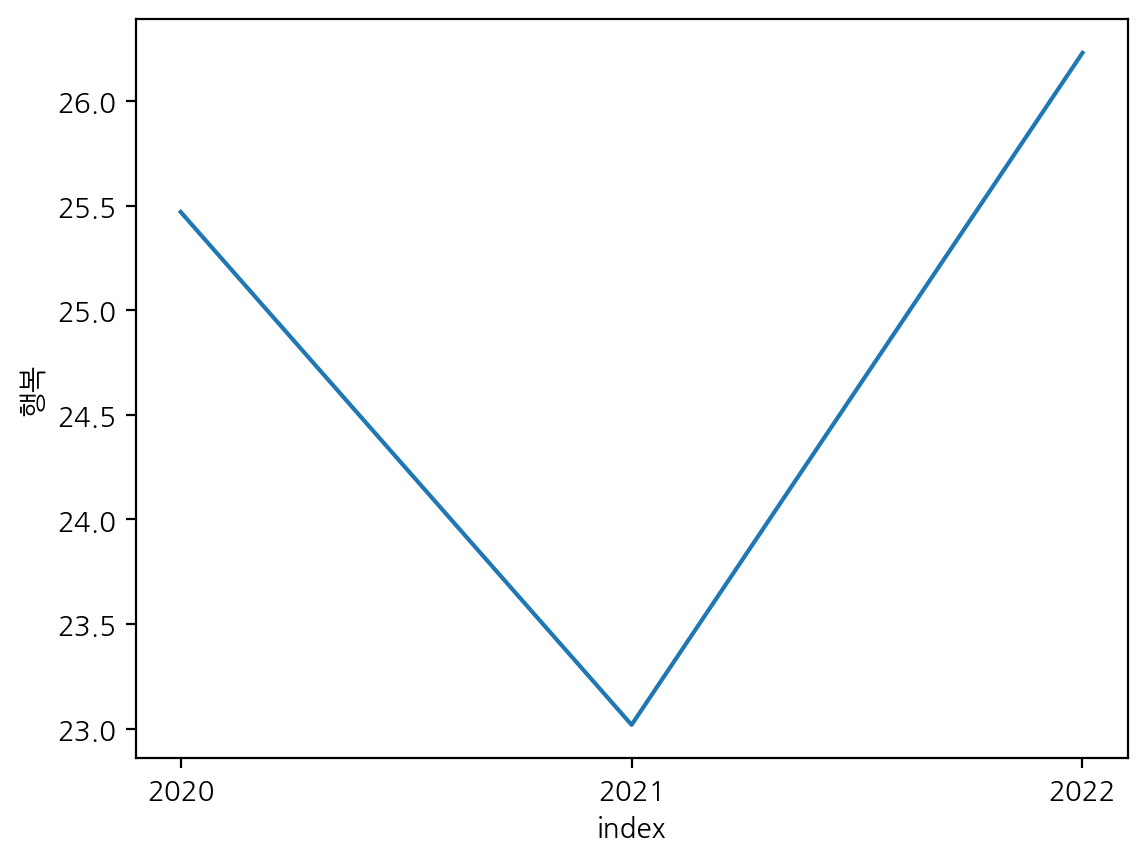

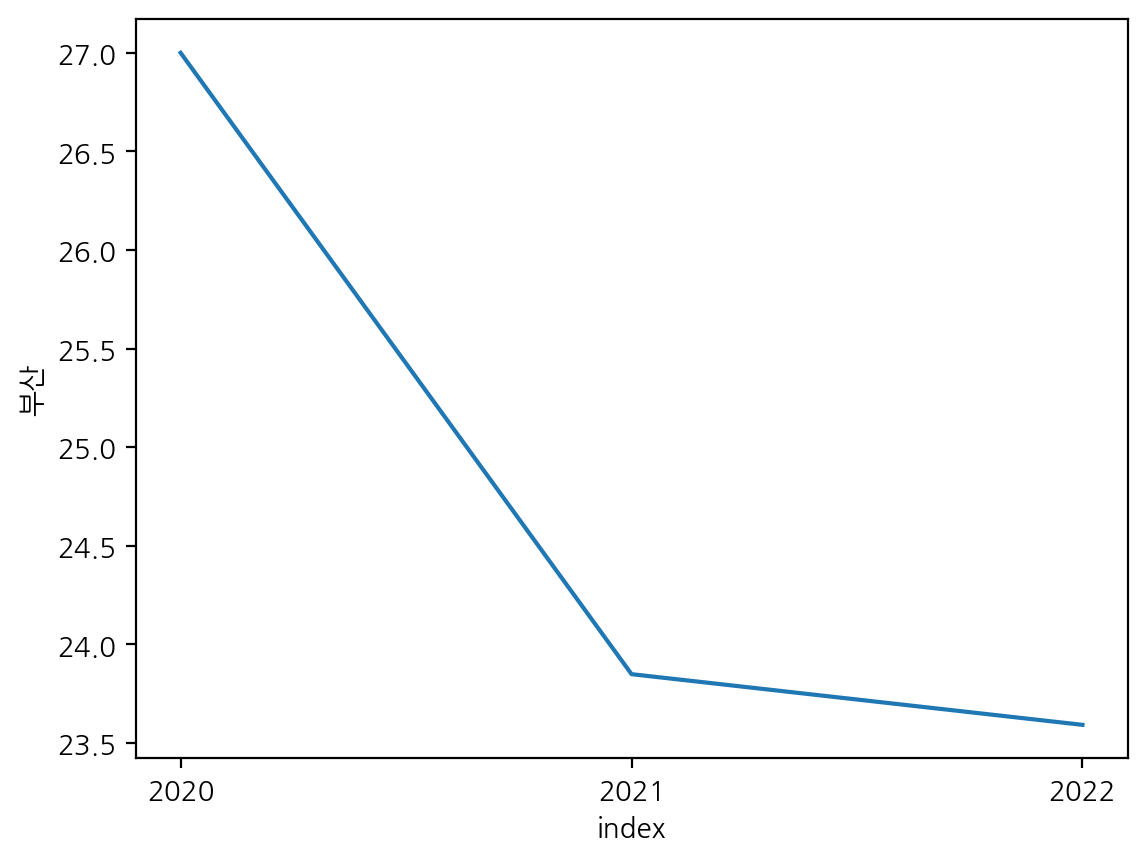

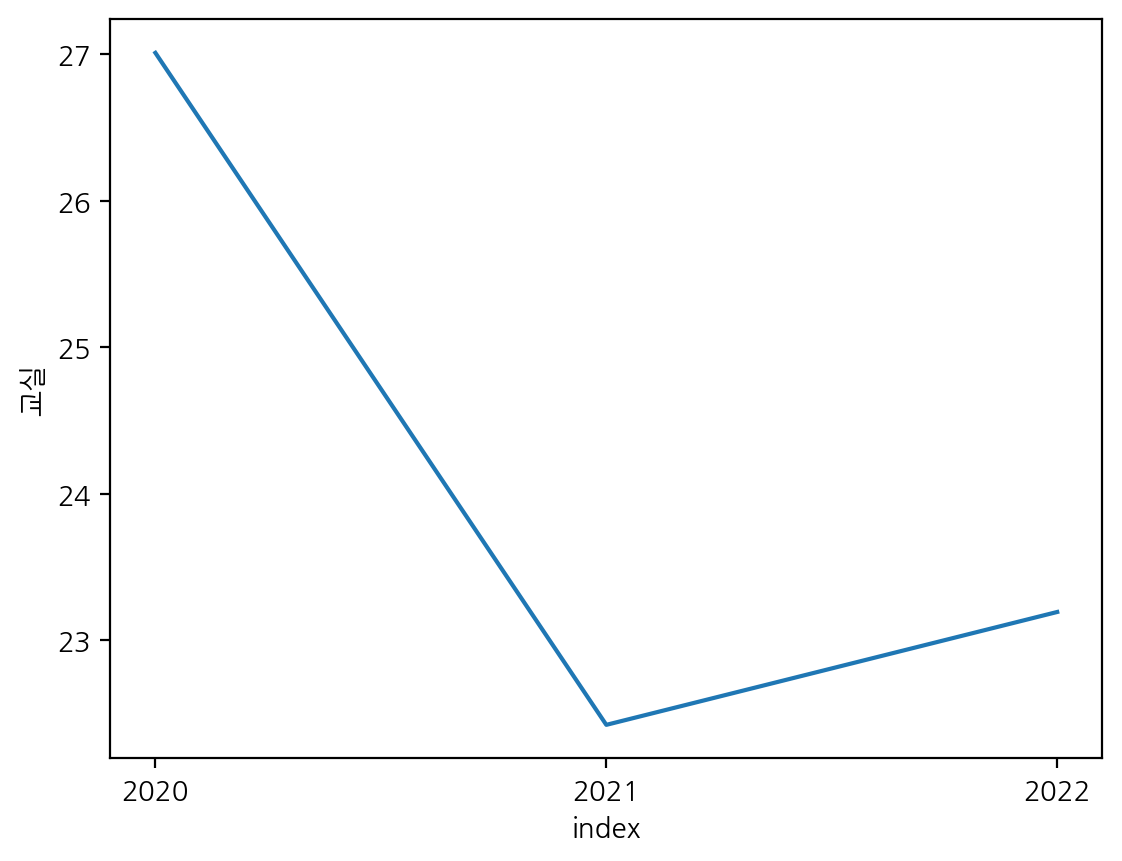

In [27]:
# 그래프 그리기
for col in cols:
    sns.lineplot(data=df, x="index", y=col)
    plt.show()